# Julia 6: Introduction to ModelingToolkit
### Bernt Lie
#### University of South-Eastern Norway
#### October 2023
## 0. Preamble
### 0.1. Content
This notebook gives an introduction to the modeling language ModelingToolkit for Julia. ModelingToolkit is a language within Julia for describing mathematical models, consisting of differential equations, algebraic equations, optimization problems, etc. ModelingToolkit uses package `Symbolics` for symbolic manipulation of models -- package `ModelingToolkit` handles import of needed `Symbolics` code, so there is no need to separately import `Symbolics`. In the final stage, `ModelingToolkit` converts the symbolic form to a numeric form. In order to solve the numeric form, solvers from the `DifferentialEquations` (and other packages in the case of optimization) are needed.

This document is organized as follows:

0. This preamble continues with information about how to install packages on your computer, how to import them in this computational session, and adds some "constants" that are used to give uniform plot results that can easily be changed in one central location (= Section 0.3). Furthermore, there is a general discussion of unbalanced vs. acausal vs. balanced model. Next, a discussion of differential algebraic equations (DAE:s) and index. A brief overview of a possible convention for converting mathematical symbols to Julia identifiers. Finally, two utility functions are included for doing symbolic linearization of *acausal* models with specified inputs and outputs assuming a DAE of index 1. The utility functions have only been tested for *simple* models with symbols in the global namespace. 

1. Introduces as a first example a model of liquid amount (water?) in a tank. Next follows a *best practice* of how to implement such a model in Julia package `ModelingToolkit.jl` [MTK for short]. Emphasis is put on a general and safe way of declaring variables and parameters *with default values*, and equations leading to an *acausal* symbolic model. In order to balance the model, it is necessary to define inputs to the model; the balanced model is then index-reduced/simplified in preparation of converting the model from a symbolic to a numeric model. A general section on how to inspect/explore model fields follows. Next, the balanced and index-reduced model is then explored. Finally, in a *postscript*, alternative ways of implementing the model is discussed, with some motivation for the chosen "best practice".

2. Discusses how to convert the symbolic model to a numeric problem in a structured way, and how to find the solution of the model followed by crude plotting of the results. Finally, a section goes into more details about the solution *data structure*, with interpolation and high quality plotting. 

3. Introduces the MTK *component class* concept as a first step to create re-usable models. This is illustrated by creating a component class of the liquid tank model introduced in Section 1, and then instantiating two copies/objects/instanses of this class. Next, these two copies are connected, and the complete system is simulated. 

4. Simulation is an interactive process, with multiple re-doing of simulations. This section discusses how to *change* the model with a different input function. As an example, it is shown how to find steady state of the model and inject a step input. Some critical thinking around numeric solvers is discussed in connection with this. Next, the case of zero inflow is studied: this leads to numeric problems, and illustrates the need to reformulate models operating under extreme conditions. Finally, efficient ways of changing model "parameters" is shown, and is used to illustrate Monte Carlo simulation of parameter (and initial state) uncertainty. 

5. So far, only the liquid tank case has been studied -- which leads to a simplified DAE 0 = Ordinary Differential Equation model. In case the simplified model is of index 1, a solver with mass matrix support must be used. This section uses a model of incompressible liquid pipe flow to illustrate a simplified model with both differential and algebraic equations (= DAE of index 1), and how to solve this with a mass matrix solver. For variation, the MTK formulation is slightly different than in Section 2; in a final "Problem" section, a challenge to convert the model to the style of Section 2 is given.

6. Symbolic and numeric *linearization* is important for "small signal" analysis of dynamic behavior. This section discusses how to do linearization of *acausal* (and non-simplified) models with included utility functions as well as via functionality in MTK and the `ControlSystems.jl` package.

7.  The real power of MTK lies in the possibility to create model libraries. A key library is the `ModelingToolkitStandardLibrary.jl` [MTK-SL]. To understand how to use MTK-SL, two components (classes) from MTK-SL are used to define causality/inputs and outputs for the liquid tank class. Next, another component is designed which uses a source component from MTK-SL (step input) and two copies from the causal tank class, and connects these into a system of two tanks --- similar to in Section 3. Use of causal blocks with MTK-SL allows us to insert so-called *analysis points* into the signal pathway. The complete model is then *built* and simulated. Finally, it is illustrated how the inclusion of "analysis points" enables the possibility to *linearize* the model around an operating point, and combine the linearized model with the `ControlSystems.jl` package.

8. Finally, the expected knowledge and competence gained from this notebook are summarized.

### 0.2. Installing packages

In [1]:
#= ... in case this has not been done already
using Pkg
Pkg.add(["ModelingToolkitStandardLibrary", "Plots"])
=#

### 0.3. Importing packages

In [2]:
using ModelingToolkit, ModelingToolkitStandardLibrary.Blocks
using DifferentialEquations
using ControlSystems, ControlSystemsMTK
using LinearAlgebra
using Plots, LaTeXStrings
using BenchmarkTools
using Latexify

### 0.4. Constants

In [3]:
# Specifying line properties as constants makes it possible to globally 
# change these values and keep consistency
LW1 = 2.5
LW2 = 2
LW3 = 1.5

LC1 = :red
LC2 = :blue
LC3 = :green
LC4 = :orange

LS1 = :solid 
LS2 = :dash
LS3 = :dashdot

LA1 = 1
LA2 = 0.5
LA3 = 0.15

# Modify the `figpath` to suit your own computer structure
figpath = "C:/Users/Bernt_Lie/OneDrive/Documents/booksBLSOL/ModDynSyst/figs/"
figtype = ".svg"
SAVEFIG = false
;

### 0.5. Unbalanced, Acausal, and Balanced model

When the number of equations $n_\mathrm{e}$ differs from the number of unknowns $n_\mathrm{u}$, the model is *unbalanced*: to be able to *solve* the model, the model must be *balanced*, i.e., the number of equations must be equal to the number of unknowns.

If we intentionally have more unknowns than equations ($n_\mathrm{u} > n_\mathrm{e}$), this can be *interpreted* as having freedom to specify $n_\mathrm{i} = n_\mathrm{u} - n_\mathrm{e}$ inputs. Because of this freedom to choose which variables are the inputs (= cause), we will denote the model *acausal*; the term "acausal" simply means that we --- so far --- have left the causality (i.e., the inputs) as an open choice to the user.

Before simulating the system, we must, however, choose what the actual inputs are --- and thus "causalize" the model to make it *balanced*. These inputs must be known functions of time.

### 0.6. Naming convention for quantities
It is useful to have a systematic convention for how to write mathematical symbols as Julia identifiers. In principle, Julia supports Unicode symbols. This means that one *could* write subscripts, add decorations such as dot on top, etc. to identifiers in Julia/ModelingToolkit.

However, using Unicode creates problems for the case where we want to insert the code in word processors with limited support for Unicode support in computer code listings. Because of this, until Unicode support becomes more widespread, we will use the following convention here:

$$
\frac{\mathrm{d} x}{\mathrm {d}t} \rightarrow \text{Dt(x)} \\
\dot{x} \rightarrow \text{xd} \\
\tilde{x} \rightarrow \text{xt} \\
\hat{x} \rightarrow \text{xh} \\
x' \rightarrow \text{xp} \\
x'' \rightarrow \text{xpp} \\
x_j \rightarrow \text{x\_j} \\
x^j \rightarrow \text{x\_\_j} \\
x_j^i \rightarrow \text{x\_j\_\_i}
$$
Greek letters will normally be spelt out in Latin, e.g., $\rho \rightarrow \text{rho}$, $\nu \rightarrow \text{nu}$, $\Delta \rightarrow \text{Delta}$, etc.

For chemical species, a syntax without subscript will be used, e.g., $\mathrm{H_2O} \rightarrow \text{H2O}$, etc.


### 0.7. Simplification and index reduction
We often formulate models as Differential Algebraic Equations [DAE:s], it is useful to have a basic understanding of DAE:s. Furthermore, DAE:s of *index 1* are important when we want to solve our models. DAE:s that we will meet can often be described in the following form:
$$
M\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,u;t)
$$
where $M$ is a possibly singular matrix and there are some requirements on $f(\cdot)$.

If matrix $M$ is non-singular = has full rank = can be inverted, we can always convert the model to an Ordinary Differential Equation [ODE] as 
$$
\frac{\mathrm{d}x}{\mathrm{d}t} = M^{-1}\cdot f(x,u;t)
$$

An ODE is a DAE of index 0, and can be solved by ODE solvers. 

If $M$ is singular, we can *not* use a standard ODE solver. Suppose the structure of $M$ is block diagonal with non-singular $M_1$ in the first diagonal block and $M_2 = 0$ in the second, and we partition $x$ into $x_1, x_2$, we can write the equation as
$$
M_1 \frac{\mathrm{d}x_1}{\mathrm{d}t} = f_1(x_1,x_2,u;t) \\
0 = f_2(x_1,x_2,u;t).
$$
The system is then a DAE of index 1 if the Jacobian $\partial f_2(x_1,x_2,u;t)/\partial x_2$ is non-singular for all values of $(x_1,x_2,u;t)$, in other words, we can solve the second equation wrt. $x_2$ and insert the resulting expression into the first equation.

If the system is a DAE of index 1, we can solve the model using mass matrix DAE solvers where we specify $M$.

If the system is a DAE of *index higher than 1*, it is possible to algorithmically reduce it to an index 1 DAE by eliminating variables and/or adding new variables.

### 0.8. Utility functions

In [4]:
function get_symbols(eqs)
    symbs = [reduce(vcat,[Symbolics.get_variables.(eq.lhs) for eq in eqs]); 
        reduce(vcat,[Symbolics.get_variables.(eq.rhs) for eq in eqs])]
    idxs_params = isequal.(expand_derivatives.(Differential(t).(symbs)),0)
    params = unique(symbs[idxs_params])
    vars = unique(symbs[isequal.(idxs_params,0)])
    return vars, params
end
;

In [5]:
function linearize_symbolic_dae01(eqs, u_mod, y_mod; x_opt = [])
    #
    # This function assumes that `eqs` represents an index 1 DAE 
    #
    # eqs: Symbolics partial model equations, i.e., with inputs undefined
    # u_mod: vector of variables which are inputs in `eqs`
    # y_mod: vector of variables in `eqs` which are outputs (inputs not allowed)
    # x_opt: optional state vector ξ if other than differential variables x
    #
    # Unknown dependent variables v 
    vars,_ = get_symbols(eqs)
    n_v = length(vars)
    #
    # Equations eqs split up into lhs and rhs
    eqs_lhs = [eq.lhs for eq in eqs]
    eqs_rhs = [eq.rhs for eq in eqs]
    n_eqs = length(eqs)
    # -- getting vec_field to be of correct size and type
    vec_field = eqs_rhs
    #
    # Determining which equations are differential, and which are algebraic
    # -- vector of derivatives; used for finding differential variables
    dvdt_mod = Differential(t).(vars)
    # -- assuming that only eqs_lhs has time derivatives of variables
    idxs_eq_d = filter(!isnothing,[findfirst(isequal.(eq,dvdt_mod)) for eq in eqs_lhs])
    idxs_eq_a = setdiff(1:n_eqs,idxs_eq_d)
    #
    # Finishing up vec_field
    vec_field[idxs_eq_d] .= eqs_rhs[idxs_eq_d]
    vec_field[idxs_eq_a] .= eqs_rhs[idxs_eq_a] .- eqs_lhs[idxs_eq_a]
    #
    # Finding Jacobian
    J = Symbolics.jacobian(vec_field,vars)
    #
    # Finding vars indices of inputs, differential variables, algebraic variables, outputs
    idxs_u = [findmax(isequal.(u,vars))[2] for u in u_mod]
    # -- differential and algebraic variables
    idxs_x = filter(!isnothing,[findfirst(isequal.(dvdt_mod,eq)) for eq in eqs_lhs])
    idxs_z = setdiff(1:n_v, idxs_u, idxs_x)
    # -- checking that inputs are not differential variables
    if !isdisjoint(idxs_x,idxs_u)
        println("Inputs can not be differential variables.")
        println("Inputs: $(u_mod)")
        println("Differential variables: $(v_mod[idxs_x])")
    end
    # -- outputs
    idxs_y = [findmax(isequal.(y,vars))[2] for y in y_mod]
    # -- checking that outputs are not inputs
    if !isdisjoint(idxs_y,idxs_u)
        println("Outputs can not be inputs.")
        println("Outputs: $(y_mod)")
        println("Inputs: $(u_mod)")
    end
    #
    # Deconstructing Jacobian
    J_d_x = J[idxs_eq_d,idxs_x]
    J_d_z = J[idxs_eq_d,idxs_z]
    J_d_u = J[idxs_eq_d,idxs_u]
    J_a_x = J[idxs_eq_a,idxs_x]
    J_a_z = J[idxs_eq_a,idxs_z]
    J_a_u = J[idxs_eq_a,idxs_u]
    #
    # Jacobian matrix for outputs; contains ones and zeros
    n_y = length(idxs_y)
    J_y = zeros(n_y,n_v)
    for i in 1:n_y
        J_y[i,:] = isequal.(y_mod[i],vars)
    end
    J_y_x = J_y[:,idxs_x]
    J_y_z = J_y[:,idxs_z]
    J_y_u = J_y[:,idxs_u]
    #
    # Finding LTI Matrices assuming differential variables are states
    # -- A and B matrices
    AA = simplify.(J_d_x - J_d_z*(J_a_z\J_a_x))
    BB = simplify.(J_d_u - J_d_z*(J_a_z\J_a_u))
    # -- C and D matrices
    CC = simplify.(J_y_x - J_y_z*(J_a_z\J_a_x))
    DD = simplify.(J_y_u - J_y_z*(J_a_z\J_a_u))
    #
    #-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
    # Checking whether optional states are requested
    #-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
    n_x = length(idxs_x)
    n_ξ = length(x_opt)
    #
    if n_ξ == 0
        return AA, BB, CC, DD, vars[idxs_x]
    elseif n_ξ != n_x
        println("Incorrect size of optional state")
        return AA, BB, CC, DD, vars[idxs_x]
    else
        # Finding transformation matrix TT from original to new state
        # -- indices for new state
        idxs_ξ = [findmax(isequal.(x,vars))[2] for x in x_opt]
        # Jacobian matrix for new state; contains ones and zeros
        J_ξ = zeros(n_ξ,n_v)
        for i in 1:n_ξ
            J_ξ[i,:] = isequal.(x_opt[i],vars)
        end
        J_ξ_x = J_ξ[:,idxs_x]
        J_ξ_z = J_ξ[:,idxs_z]
        J_ξ_u = J_ξ[:,idxs_u]
        #
        TT = simplify.(J_ξ_x - J_ξ_z*(J_a_z\J_a_x))
        TT_u = simplify.(J_ξ_u - J_ξ_z*(J_a_z\J_a_u))
        # -- not allowed to have inputs in ξ, i.e., must require TT_u ≡ 0
        if sum(isequal.(isequal.(TT_u,0),0)) != 0
            println("Optional states lead to input derivatives")
            return AA, BB, CC, DD, vars[idxs_x]
        end
        AA_ = simplify.(TT*AA/TT)
        BB_ = simplify.(TT*BB)
        CC_ = simplify.(CC/TT)
        DD_ = DD
        #
        return AA_, BB_, CC_, DD_, x_opt
    end
end
;

## 1. Liquid Tank model --- implementation in ModelingToolkit
### 1.1. Model of tank
We consider the following model of a simple water tank with mass $m$, influent mass rate  $\dot{m}_\mathrm{i}$, effluent mass rate $\dot{m}_\mathrm{e}$,
$$
\frac{\mathrm{d}m}{\mathrm{d}t} = \dot{m}_\mathrm{i} - \dot{m}_\mathrm{e}
$$
Water has density $\rho$, leading to a water volume $V$ contained in the tank which has constant cross sectional area $A$. The resulting water level is $h$, 
$$
m = \rho\cdot V \\
V = A\cdot h
$$
We will assume that the effluent is driven by gravity, and can be related to water level via a Bernoulli type rate
$$
\dot{m}_\mathrm{e} = K\cdot \sqrt{\frac{h}{h^\varsigma}}
$$
In summary: we have
* 4 parameters:  $\rho$, $A$, $K$, $h^\varsigma$
* 5 unknowns $m$, $\dot{m}_\mathrm{i}$, $\dot{m}_\mathrm{e}$, $V$, $h$. 
* 4 equations

In this case study, we will assume the following model parameters:
$$
\rho = 1 \\
A = 5 \\
K = 5 \\
h_\varsigma = 3
$$

Although several possibilities are available for choice of input, the *natrual* input from a physics point-of-view is $\dot{m}_\mathrm{i}$.

### 1.2. Variables and parameters

1. Start by defining the *independent variable*, normally `t` for dynamic systems
2. Next, define a short for the differential operator. Here, `Dt` is used to also indicate the independet variable.
3. Next, specify a named *parameters* object in a `begin...end` block *with default values* - it is recommended to add description of the parameters.
4. Next, specify a named *variables* object in a `begin...end` block, use as many default variables as useful.

Example for the tank model:

In [6]:
# 1. Independent variables
@variables t 
# 2. Differential operator
Dt = Differential(t)
# 3. Parameters
pars = @parameters begin 
    ρ=1,    [description = "Liquid density"]
    A=5,    [description = "Cross sectional tank area"]
    K=5,    [description = "Effluent valve constant"]
    h_ς=3,  [description = "Scaling level in valve model"]
end
# 4. Dependent variables 
vars = @variables begin
    (m(t)=1.5*ρ*A),   [description = "Liquid mass"]
    md_i(t),         [description = "Influent mass flow rate"]
    md_e(t),         [description = "Effluent mass flow rate"]
    V(t),           [description = "Liquid volume"]
    h(t),           [description = "Liquid level"]
end
;


Note: for some reason, it is necessary to add a parenthesis around `m(t)=1.5*ρ*A` at the time of this writing. This need disappears when the model is built via a `@mtkmodel` macro as in Section 3.

### 1.3. Specifying *acausal/unbalanced* model

Next, 
* Set up a vector of equations for the system.
* Create the *acausal* model using constructur `ODESystem`.
* Use the additional arguments of independent variables, variables, and parameters for constructor `ODESystem` to make sure that no parameters, etc. are "forgotten".

In Julia, symbol `=` implies *assignment*. Because this symbol thus already is taken, language ModelingToolkit instead uses symbol `~` to signify mathematical equality. [NOTE: `~` is the symbol found on the computer keyboard. Do *not* use the $\LaTeX$ symbol `\sim`.]

The resulting equations/model will be *unbalanced*:

In [7]:
eqs = [
    Dt(m) ~ md_i-md_e,
    m ~ ρ*V,
    V ~ A*h,
    md_e ~ K*sqrt(h/h_ς)
 ]

@named tank = ODESystem(eqs, t, vars, pars)    # Acausal tank model, i.e., without defined input functions

Model tank with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]: Liquid mass
  md_i(t): Influent mass flow rate
  md_e(t): Effluent mass flow rate
  V(t): Liquid volume
⋮
Parameters (4):
  ρ [defaults to 1]: Liquid density
  A [defaults to 5]: Cross sectional tank area
  K [defaults to 5]: Effluent valve constant
  h_ς [defaults to 3]: Scaling level in valve model

Observe that this is a *symbolic* description of the model. So far, there is no requirement that the model is balanced, i.e., it is possible to specify a system with different number of equations and unknowns.

In particular, note that in `eqs` (equations) and `tank` (model), we have *5 unknowns* [$m$, $\dot{m}_\mathrm{e}$, $\dot{m}_\mathrm{i}$, $V$, $h$], and only *4 equations* - hence the model is unbalanced.

### 1.4. Creating balanced model followed by index reduction
So far, we have not defined *causality*, i.e., we have not stated which one of the 5 unknowns is a known time function. In principle, we can choose any of the 5 unknowns as input, but from physics, the logical choice is to set $\dot{m}_\mathrm{i}$ equal to a known function of time - which we will name $\dot{m}(t)$.

ModelingToolkit command `structural_simplify` performs reduction of the original model to a DAE of index 1, and more: `structural_simplify` removes redundant equations, removes redundant variables and puts them into a class `observed`, and reduces the equations to a DAE of index 1. ModelingToolkit automatically handles the set-up of the $M$ matrix - we don't have to think about it. We only need to know that we must use a solver with support for mass matrix.

**NOTE**: In order for `structural_simplify` to work, it must be possible to reduce the model to a system where the number of equations and the number of remaining unknowns are equal, i.e., we must provide a balanced system with the same number of equations and unknowns.

Here is how we procede, 
* Register the symbolic input function $\dot{m}(t)$.
* Formulate equations for connecting the input function to acausal model variables; here $\dot{m}_\mathrm{e}$.
* Create a balanced model by combining the acausal model with the input connectivity model.
* Do index reduction of the balanced model to create DAE index 1 model.

First: we register a symbolic input function.

In [8]:
@register_symbolic md(t)

Next, formulate the model for connecting input function to variables. We will show two ways of doing this.

#### 1.4.1. *Extending* the acausal model
One approach of creating a balanced model is to create input equations and then `extend` the acausal model with the input equations. The resulting model has variables in the global namespace. Next, we simplify the model (`structural_simplify`), which reduces the model to a DAE of at most 1.

In [9]:
eqs_i = [md_i ~ md(t)]

@named tank_i = ODESystem(eqs_i, t)

tank_bal = extend(tank,tank_i)

tanksys = structural_simplify(tank_bal)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]: Liquid mass
Parameters (4):
  ρ [defaults to 1]: Liquid density
  A [defaults to 5]: Cross sectional tank area
  K [defaults to 5]: Effluent valve constant
  h_ς [defaults to 3]: Scaling level in valve model
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

#### 1.4.2. *Composing* the two models
Alternatively, we `compose` the input equations and the acausal equations to create the balanced model. In this case, the resulting model will have variable names associated with the `tank` model (name of acausal model). Because of this, we need to add the `tank` as name to the input, thus the input must be referred to as `tank.md_i` instead of just `md_i`; compare the use of `extend`.

Also, after the simplification of the model, function `complete` should be applied to the model (e.g., by "function piping") to ensure that MTK properly handles the name `tank`.

In [10]:
eqs_i_1 = [tank.md_i ~ md(t)]

@named tank_i_1 = ODESystem(eqs_i_1, t)

tank_bal_1 = compose(tank_i_1,tank)

tanksys_1 = structural_simplify(tank_bal_1) |> complete

Model tank_i_1 with 1 equations
States (1):
  tank₊m(t) [defaults to 1.5tank₊A*tank₊ρ]: Liquid mass
Parameters (4):
  tank₊ρ [defaults to 1]: Liquid density
  tank₊A [defaults to 5]: Cross sectional tank area
  tank₊K [defaults to 5]: Effluent valve constant
  tank₊h_ς [defaults to 3]: Scaling level in valve model
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

#### 1.4.3. Why separate acausal and input-connection models?
The purpose of splitting the model into the *acausal* model and the *input* model is that we can then later do symbolic linearization of the *acausal* model; in the linearization procedure, we need to have more unknowns (= inputs) than equations.

In the sequel, we will consider the *extended* model -- for simplicity.

### 1.5. Model fields and functions
#### 1.5.1. Fields
Constructor `ODESystem` creates a data structure/object with certain fields. From the documentation of `ODESystem`, some of the most basic fields are:

`name`: Name: the name of the system.

`eqs`: The ODEs defining the system.

`iv`: Independent variable.

`ps`: Parameter variables. Must not contain the independent variable.

`states`: Dependent ("state") variables. Must not contain the independent variable.

`observed`: Observed states.

`defaults`: defaults: The default values to use when initial conditions and/or parameters are not supplied in ODEProblem.

`metadata`: metadata for the system (e.g., units), to be used by downstream packages.

Let us check out some of these fields.

In [11]:
tank.name, tanksys.name

(:tank, :tank)

In [12]:
tank.eqs

Equation[Differential(t)(m(t)) ~ md_i(t) - md_e(t), m(t) ~ V(t)*ρ, V(t) ~ A*h(t), md_e(t) ~ K*sqrt(h(t) / h_ς)][1:4]

In [13]:
tanksys.eqs

Equation[md_i(t) ~ md(t), Differential(t)(m(t)) ~ md_i(t) - md_e(t), m(t) ~ V(t)*ρ, V(t) ~ A*h(t), md_e(t) ~ K*sqrt(h(t) / h_ς)][1:5]

In [14]:
tank.iv, tanksys.iv

(t, t)

In [15]:
tank.ps, tanksys.ps

(SymbolicUtils.BasicSymbolic{Real}[ρ, A, K, h_ς][1:4], SymbolicUtils.BasicSymbolic{Real}[ρ, A, K, h_ς][1:4])

In [16]:
tank.states, tanksys.states

(SymbolicUtils.BasicSymbolic{Real}[m(t), md_i(t), md_e(t), V(t), h(t)][1:5], SymbolicUtils.BasicSymbolic{Real}[md_i(t), m(t), md_e(t), V(t), h(t)][1:5])

In [17]:
tank.observed, tanksys.observed

(Equation[][1:0], Equation[][1:0])

In [18]:
tank.defaults, tanksys.defaults

(Dict{Any, Any}(h_ς => 3, K => 5, m(t) => 1.5A*ρ, A => 5, ρ => 1), Dict{Any, Any}(h_ς => 3, K => 5, m(t) => 1.5A*ρ, A => 5, ρ => 1))

In [19]:
tank.metadata

Because we have not defined any metadata in the model, this field is empty.

#### 1.5.2. Functions
To complement the fields listed above, the information can be extracted via functions.

We will focus on functions `equations`, `full_equations`, `states`, `observed`, and `parameters`. There is also a function `defaults` - but this one is not *exported* by default, and needs to be called as `ModelingToolkit.defaults()`.

### 1.6. Exploring DAE simplified model
It is useful to understand the *structurally simplified* DAE model of index 1. We will do this by considering *equations*, *states*, *observed*, *parameters*, and *defaults*.

**Equations**

First, let us see the equation that follows using function `equation`:

In [20]:
equations(tanksys)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ md_i(t) - md_e(t)

The main things to see from this form is:
1. The number of equations that need to be solved numerically (=1).
2. Whether the equations are differential equations or a combination of differential and algebraic equations (here: only a signle differential equation; no algebraic equations).

If the result above only contains differential equations, then the model can be solved by ODE solvers. If some of the equations are algebraic, then a solver with Mass Matrix must be used.

The equation in response to the `equations` function above is not in a form that can be solved --- we know the initial value of $m$ and the input function $\dot{m}_\mathrm{i}$, but there is a dependence of $\dot{m}_\mathrm{e}$ on $m$ that is not given. The actual equation that is solved is found by function `full_equations`:   

In [21]:
full_equations(tanksys)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ md(t) - K*sqrt(m(t) / (A*h_ς*ρ))

The equation resulting from `full_equations` is an ODE that can actually be solved.

**States**

In the ModelingToolkit *lingo*, "state" means *unknown* in the *structurally simplified model*, i.e., it equals $x$ in the simplified index 1 DAE model $M\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,u;t)$.

These unknowns are provided by function `states`:

In [22]:
states(tanksys)

1-element Vector{Any}:
 m(t)

In fact, it is the variables shown by command `states(tank_simp)` that we need to provide initial values for.

**Observed**

When going from the original model formulation with its specified *variables*, doing `structural_simplify` removes some of these variables because they are not needed in the reduced index 1 DAE. These *removed* variables are denoted *observed*. The *observed* variables are not involved when finally solving the model numerically, but ModelingToolkit still needs to keep track of them so that they can be plotted, etc. 

To this end, let $x$ be the "states" in the index 1 DAE simplified model, and let $\omega$ be the *observed* variables. `structural_simplify` then removes $\omega$ from the model, but will still keep track of how $\omega$ can be computed as $\omega = g(\omega,x,u)$ (where the $\omega$ dependence in $g(\cdot)$ is such that $\omega$ can be easily computed, e.g., $\omega_1 = g_1(x,u)$, $\omega_2 = g_2(\omega_1,x,u)$, etc.). The unknowns in the union of $x$ and $\omega$ will provide the solution to all variables in the *original* model, i.e., before structural simplification.   

In [23]:
observed(tanksys)

4-element Vector{Equation}:
 md_i(t) ~ md(t)
 V(t) ~ m(t) / ρ
 h(t) ~ V(t) / A
 md_e(t) ~ K*sqrt(h(t) / h_ς)

The `observed` variables are variables that can easily be computed after the `states` variables have been found; `observed` variables have not been forgotten. The reason for splitting out `observed` variables is to reduce as much as possible the number of unknowns (`states`) that are computed by the numerical solver.

**Parameters**

We can also check which parameters are used in the model:

In [24]:
parameters(tanksys)

4-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 ρ
 A
 K
 h_ς

**Defaults**

Finally, we can check what default values have been specified (parameters + initial values of variables) --- this is done with function `defaults`. **NOTE** that function `defaults` in the MTK package is *not* "exported" in the package. This means that we need to include the package name when calling this particular function, i.e., it must be called as `ModelingToolkit.defaults`:

In [25]:
ModelingToolkit.defaults(tanksys)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

**Summary**

Note that the concept of "state" in ModelingToolkit may be different from the way "state" is defined in traditional dynamic systems literature, but here the interpretations coincide.

ModelingToolkit refers to the unknowns (after structural simplification?) as states. The remaining unknowns are computed by some hidden algebraic relations, and are referred to as *observables* or *observed variables*.

The *parameters* are constants in the model. Before we can solve a model numerically, numeric values for all parameters must be provided, together with initial values for the "states" in the model. If these quantities have been given default numeric values, we can in principle solve the model numerically.

If some of the parameters + states are lacking default numeric values, or if we want to change the values, this can be done when we convert the symbolic model to a numeric value - see below.

### 1.7. Postscript
There are several possible ways of defining MTK models. The approach introduced so far can be considered "best practice". Here, we discuss some alternatives, and why the approach introduced above has been chosen.

#### 1.7.1. Parameters and Variables
Both parameters and variables can be created without naming them (as indicated by creating independent variable `t` via `@variables t`). 

Parameters and variables can be listed after the respective macro names as separated by space on a single line, separated by comma on a single line, or provided in a tuple which can stretch over several lines. Examples:
```julia
@parameters a b
@parameters c, d
@parameters (e, f,
                g)
```
With the above construct, we have defined parameters `a, b, c, d, e, f, g` without giving default values. Similarly, we can create a number of variables spread over several macro statements and lines.

**NOTE**: dependent variables must be specified "as a function of" the independent variable, e.g., 
```julia
@variables t x(t) y(t)
```
indicates *independent* variable `t` and two dependent variables `x` (or: `x(t)`) and `y` (or: `y(t)`).

Variables and parameters can be created with or without numeric values:
```julia
@parameters a=1, b=3, c
@variables x(t) = 1, y(t)
```

Adding numeric values to parameters is considered *default* values for the parameters. Adding numeric values to dependent variables is considered *default initial* values for the variables.

A fourth way to specify parameters and variables (i.e., in addition to separation by space, comma, and in tuple) is via a `begin...end` block, as indicated in the "best practice" code in previous sections.

#### 1.7.2. Call signature of `ODESystem`
In the "best practice" code in previous sections, we have used the call signature `ODESystem(eqs, independent_variable, variables, parameters)` for model constructor `ODESystem()`.

The simplest possible call signature is `ODESystem(eqs)`, where MTK functions have to parse the equations `eqs` and figure out (i) what is/are the independent variable(s), (ii) what are the dependent variables, and (iii) what are the parameters. This call structure (`ODESystem(eqs)`) is typically used in introductory examples of ModelingToolkit.

There may be cases where the parser struggles to figure out what the independent variable is, and it may therefore be safer to specify the independent variable *explicitly* in order to help the constructor.

However, the problem is more severe with *parameters*. Suppose we have the following parameters, variables, and equations:
```julia
@variables t
Dt = Differential(t)
@parameters a=1, b=a
@variables x(t)
eqs = [D(x) ~ -x/b]
```
If we use signature `ODESystem(eqs)` here, the parser will not find parameter `a` in `eqs`, and may therefore conclude that `b` is the only parameter to use. But without `a`, parameter `b` has no value, and the simulation will crash.

For a case like the above, we will need to provide the `ODESystem()` constructor with the parameter "vector" manually, and because the parameters are last in the signature `ODESystem(eqs, independent_variable, variables, parameters)`, we also need to provide independent variables, variables, as well as the parameters.

This is best done by collecting all parameters and variables in named "vectors".

#### 1.7.3. Naming parameters and variables
To make sure that we include all parameters in the "vector" of parameters, we can do any of the following:
```julia
par1 = @parameters a b
par2 = @parameters c d
pars_i = [par1; par2]
```
or:
```julia
pars_ii = @parameters (a, b,
            c, d)
```
or:
```julia
pars_iii = @parameters begin
    a
    b
    c
    d
end
```
Here, `par_i` equals `par_ii` equals `par_iii`. It seems to provide better structure if we avoid scattering the parameter vectors over several sub-vectors (as for `pars_i`). Thus, the construction methods for `pars_ii` and `pars_iii` are favored over that of `par_i`. 

Between `pars_ii` and `pars_iii`, collecting parameters in a tuple uses less vertical space (advantage), but using the `begin...end` block structure makes the code more readable, which is an advantage.

Furthermore, using the `begin...end` block structure gives more horizontal space for adding description, etc.

In summary, the `begin...end` block structure is the preferred way of creating and naming parameters. The same arguments are valid for creating and naming variables.

To this end, the example in the previous section can now be re-written:

```julia
@variables t
Dt = Differential(t)
pars = @parameters begin
    a=1
    b=a
end
vars = @variables x(t)
eqs = [D(x) ~ -x/b]

ODESystem(eqs, t, vars, pars)
```
avoids the uncertainty in parsing the equations `eqs`.

#### 1.7.4. Separating acausal model and input specification
Separating the acausal model (i.e., model `tank` in the preceding sections) from the equations related to connecting concrete input functions of time to "input" variables in the acausal model (i.e., model `tank_i` in the preceding sections), is important because it:
* makes it possible use the acausal model in a model library, and later connect it to other models/inputs as required,
* may be useful in order to allow for linearization, etc. of the model.

Linearization will not be discussed in the sequel.

## 2. Numeric problem + Solution
### 2.1. Specifying time span, input function
Before we can convert the symbolic model to a numeric model/problem, we need to:
1. Define a time span/tuple of initial time and final time,
2. Give a concrete function form to the symbolic input function (here: $\dot{m}$)

In [26]:
tspan = (0,10)

md(t) = 2 + 0.1*sin(2pi*t/4)
;

### 2.2. Converting symbolic model to numeric problem

So far, we have operated with a symbolic model (instantiated by function `ODESystem`). We now are ready to create a *numeric implementation* of the model using function `ODEProblem`, where we also need to specify:

* initial "state" - this means that we need to specify initial values for all variables given by command `states(tank_simp)`,
* time span for the simulation - in the form of a tuple consisting of the start time and end time, and 
* numeric values for all parameters.

In our case, we have actually provided default values for state and parameters, so we can convert the symbolic model `tanksys` to a numeric problem `prob` as follows:

In [27]:
prob = ODEProblem(tanksys, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 10)
u0: 1-element Vector{Float64}:
 7.5

**Note**: A fuller call signature for the `ODEProblem` function includes positional arguments `ODEProblem(model, initial_state, timespan, parameters)`. The `model` name is *required* (e.g., `tanksys`). If we want to use default values for initial states, `initial_state` is replaced by `[]`. Normally, we want to specify the timespan; above `tspan` was used for `timespan`. If we use *default parameters*, the fourth positional argument (`parameters`) can be dropped.

Observe that if some states are lacking, they must be specified in the `ODEProblem` function. Similarly for the parameters. Suppose `m(t)` is not defined, and we want to change valve constant `K` and cross sectional area `A`. This could be done as follows:

```julia
x0 = [m => 1.5*ρ*A]         # Specifying initial state(s)
par = [A => 6, K => 4]      # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)
```

In *summary*: in order to create a proper numeric problem, the *union* of default initial states and initial states defined as in `x0` above must equal the list of `states` of the model. Likewise, the *union* of default parameter values and parameter values defined as in `par` above must equal the list of `parameters` of the model.

### 2.3. Numerical *solution* of the model
To solve the numeric implementation of the model (instantiated by `ODEProblem`), we need to use *solvers* from the `DifferentialEquations.jl` package. Thus, from this stage of, the `DifferentialEquations.jl` [DE] package must have been imported.

The DE function to solve the numeric problem is named `solve`, with the name of the problem as argument. Here, we could also specify which numeric solver to use, accuracy, etc., but we will use default values initially.

If the resulting model from `structural_simplify` (either directly, or via `equations(tank_simp)` or `full_equations(tank_simp)`) consists of only differential equations, then the resulting model is a system of Ordinary Differential Equations, and an ODE solver can be used. In principle, all solvers for `DifferentialEquations.jl` under **ODE Solvers** can be used.

However, if the result from `structural_simplify` consists of both differential equations and algebraic equations, then a solver that supports *mass matrix* is required. Solvers with support for mass matrix are listed in the documentation for `DifferentialEquations.jl`, under **DAE Solvers** [more precisely, `OrdinaryDiffEq.jl (Mass Matrix)` heading].

Solving the numeric *problem* formulation `prob` is done via function `solve`, which comes from the `DifferentialEquations.jl` package. In other words, to execute the `solve` function, we must have imported the `DifferentialEquations` package.

Let us re-check that the model can use a standard ODE solver:

In [28]:
equations(tanksys)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ md_i(t) - md_e(t)

Here, we only have differential equations, and can use a default solver:

In [29]:
sol = solve(prob)
;

Function `solve` allows one to specify the numeric solver as the *second* positional argument of the `solve` function. If you want to specify solver, `Tsit5()` is one possibility. If the simplified model has a mass matrix $M$, it is required to use DAE solver which supports mass matrices, e.g., `QBDF()`.

The call would then be, e.g.,
```julia
sol = solve(prob, Tsit5())
```
It is also possible to add a number of keyword assignments to the `solve` function. Some relevant keyword assignments are `reltol` (relative tolerance), `abstol` (absolute tolerance), `saveat` (the time interval between when solutions should be saved), `tstops`(time points where we require the solution to be found --- a scalar or a vector), etc.

Example:
```julia
sol = solve(prob; reltol=1e-3)
```

### 2.4. Crude plotting of solution
The solution `sol` is a data structure containing the solution in the time points given by `sol.t` or `sol[t]`, i.e., it contains vectors of solutions. However, structure `sol` also contains interpolation functions for the solution.

In [30]:
sol.t |> permutedims    # "transpose"/permute dimension to save vertical space

1×10 Matrix{Float64}:
 0.0  0.137332  0.975789  1.94971  …  6.02354  7.45431  9.11655  10.0

In [31]:
sol[t] |> permutedims

1×10 Matrix{Float64}:
 0.0  0.137332  0.975789  1.94971  …  6.02354  7.45431  9.11655  10.0

In [32]:
sol[m] |> permutedims

1×10 Matrix{Float64}:
 7.5  7.29397  6.22246  5.2318  …  3.07625  2.69879  2.60361  2.58339

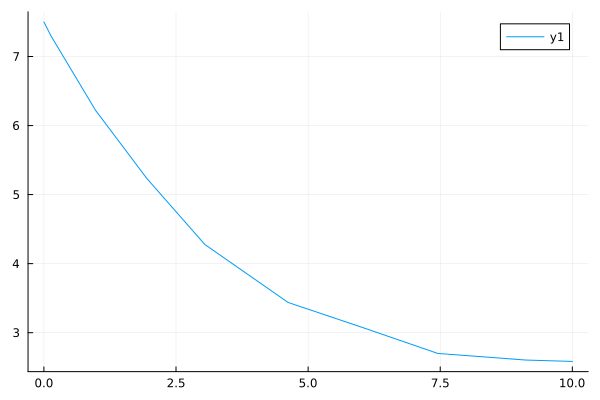

In [33]:
plot(sol[t],sol[m])

Note the jagged quality of the plot. The reason is that `plot` draws straight lines between the points given by `sol[t]` and `sol[m]`; we have only a few values of each pair `sol[t]` and `sol[m]`:

In [34]:
length(sol[t])

10

### 2.5. Understanding the solution `sol`

The solution object `sol` is dual-faced: It is a vector of solutions of the unknown variables at given time points, just like in other computing tools (as we already have seen):

In [35]:
sol.t'   # Transpose to save vertical space; alternative to using `permutedims` function

1×10 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.137332  0.975789  1.94971  …  6.02354  7.45431  9.11655  10.0

In [36]:
sol[m]'

1×10 adjoint(::Vector{Float64}) with eltype Float64:
 7.5  7.29397  6.22246  5.2318  …  3.07625  2.69879  2.60361  2.58339

The way this works is that ModelingToolkit keeps track of equations for how these non-state variables = *observed* variables relate to the states, which have actually be computed. Then the solution of these observed variables are computed from these equations.

One more example:

In [37]:
sol[h]'

1×10 adjoint(::Vector{Float64}) with eltype Float64:
 1.5  1.45879  1.24449  1.04636  0.855522  …  0.539757  0.520722  0.516677

**FEATURE!** in *addition* to holding the solution in time points given by `sol.t`, data structure `sol` *also* contains interpolations of the solution, which serves two purposes: (i) plotting the solution as an interpolation gives considerably smoother plots, and (ii) we can interpolate and compute the solution at other time instances than those provided by `sol.t`:

In [38]:
sol(0.5)

1-element Vector{Float64}:
 6.794358361705905

Observe that `sol(0.5)` provides the *state* (here: $m$) at time $t=0.5$.

Suppose that we instead want an interpolated value of *observed* variables? This can be done as follows:

In [39]:
sol(0.5; idxs = md_e)

3.3651048427713475

In [40]:
sol(0.5; idxs = [md_e, h])

2-element Vector{Float64}:
 3.3651048427713475
 1.3588716723411811

### 2.6. Smooth plotting of solution
Instead of plotting the *data points* of the solution by specifying `sol[t], sol[m]`, we can plot the *interpolation function* embedded in the `sol` data structure, which is smooth - the `plots` command chooses a number of points to compute the solution in, in order to give a nice plot.

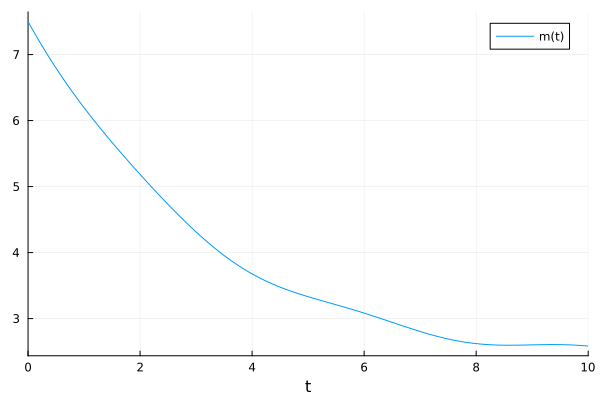

In [41]:
plot(sol)

Note the smooth quality of the plot. The reason is that `plot` here uses the *interpolation* function embedded in the solution object `sol`, and can therefore compute values for $m$ for many more time instances $t$ than the few values in `sol.t`. [Also note that `plot` adds an xlabel (`t`) and a label for the plot `m(t)`].

Let us refine the plot slightly, and plot level `h` instead of mass `m`.

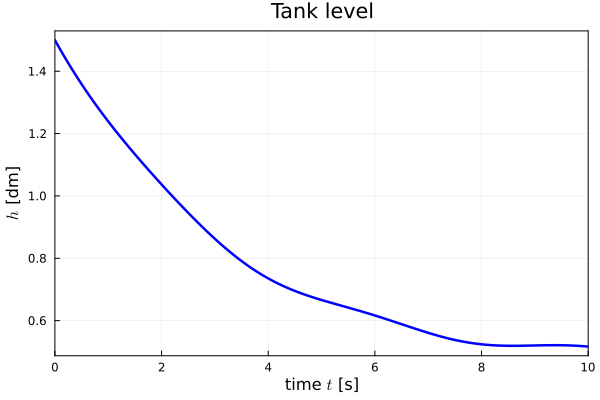

In [42]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label="")
plot!(title="Tank level", xlabel=L"time $t$ [s]",ylabel=L"$h$ [dm]")
plot!(framestyle =:box, grid=true)

In [43]:
if SAVEFIG
    figname = "drivenTankSim-1"
    savefig(figpath*figname*figtype)
end
;

We could also manually use the interpolation function as follows (to illustrate that we can interpolate in many more points than the `length(sol.t)` = 10 points when plotting the vectors of the solution).

Let us first check the result of interpolating over a sequence of numbers:

In [44]:
sol.(0:0.5:3)

7-element Vector{Vector{Float64}}:
 [7.5]
 [6.794358361705905]
 [6.195417643383901]
 [5.668986018232298]
 [5.184411022849846]
 [4.729149414952086]
 [4.312404203469169]

The result is a *vector of vectors*, but we need a simple vector of scalars. To convert the above result to the needed form, a relatively simple and efficient method is the following:

In [45]:
reduce(vcat, sol.(0:0.5:3))

7-element Vector{Float64}:
 7.5
 6.794358361705905
 6.195417643383901
 5.668986018232298
 5.184411022849846
 4.729149414952086
 4.312404203469169

Now we can do the plotting, this time with some refinements:

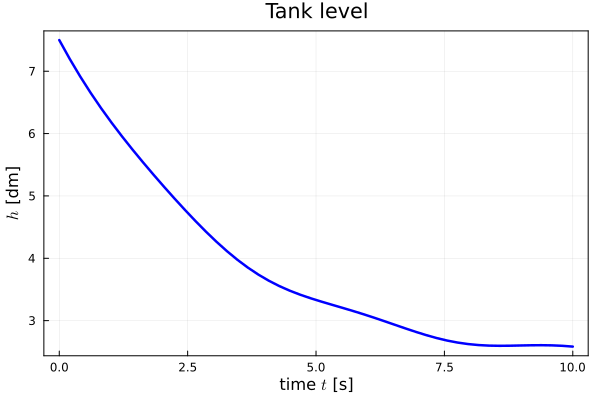

In [46]:
tm = range(0,10,length=50)
plot(tm,reduce(vcat,sol.(tm)),lc=LC2,lw=LW1,label="")
plot!(title="Tank level", xlabel=L"time $t$ [s]",ylabel=L"$h$ [dm]")
plot!(framestyle =:box, grid=true)

## 3. MTK component class
In a recent update of how to describe models in ModelingToolkit, a "best practice" for creating a component instantiator/model class is quite similar to how this is done in Modelica.
### 3.1 Defining a `Tank` model class
It is recommended to use macro `mtkmodel` to create a model instantiator.

In [47]:
# Below, macro `mtkmodel` creates a model instantiator/"class" with name `Tank`
#
@mtkmodel Tank begin
    # Model parameters
    @parameters begin 
        ρ=1,    [description = "Liquid density"]
        A=5,    [description = "Cross sectional tank area"]
        K=5,    [description = "Effluent valve constant"]
        h_ς=3,  [description = "Scaling level in valve model"]
    end
    # Model variables, with initial values needed
    @variables begin
        m(t)=1.5*ρ*A,   [description = "Liquid mass"]
        md_i(t),         [description = "Influent mass flow rate"]
        md_e(t),         [description = "Effluent mass flow rate"]
        V(t),           [description = "Liquid volume"]
        h(t),           [description = "level"]
    end
    # Providing model equations
    @equations begin
        Dt(m) ~ md_i-md_e
        m ~ ρ*V
        V ~ A*h
        md_e ~ K*sqrt(h/h_ς)
    end
end
;

Observe that:
* We have collected both parameters and variables, *as well as* equations using *macros* (`@parameters`, `@variables`, `@equations`) with `begin...end` blocks.
* The independent variable (`t`) and the differentiation operator (`Dt`) should be defined in the global scope. 
* In combination with the `@mtkmodel` macro, this set-up *automatically* inserts the resulting equations into the `ODESystems()` constructor (hidden from the user)
* This structure also inserts (without user intervention) *parameters*, etc. into the `ODESystem()` constructor, thus avoiding the parsing problem mentioned previously.

### 3.2. Instantiating models
We can now instantiate two copies of this model by:

In [48]:
@named tank_1 = Tank()
@named tank_2 = Tank()

Model tank_2 with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]: Liquid mass
  md_i(t): Influent mass flow rate
  md_e(t): Effluent mass flow rate
  V(t): Liquid volume
⋮
Parameters (4):
  ρ [defaults to 1]: Liquid density
  A [defaults to 5]: Cross sectional tank area
  K [defaults to 5]: Effluent valve constant
  h_ς [defaults to 3]: Scaling level in valve model

Observe that each of these model instances, `tank_1` and `tank_2`, are identical to model `tank` defined previously. However, their names are different:

In [49]:
tank.name, tank_1.name, tank_2.name

(:tank, :tank_1, :tank_2)

During instantiation, we can change the parameters or initial states from the default values. As an example, suppose we want to create a new `tank_3` instance with area `A` having value `6`. This is done as follows: 

In [50]:
@named tank_3 = Tank(; A=6)

Model tank_3 with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]: Liquid mass
  md_i(t): Influent mass flow rate
  md_e(t): Effluent mass flow rate
  V(t): Liquid volume
⋮
Parameters (4):
  ρ [defaults to 1]: Liquid density
  A [defaults to 6]: Cross sectional tank area
  K [defaults to 5]: Effluent valve constant
  h_ς [defaults to 3]: Scaling level in valve model

In [51]:
ModelingToolkit.defaults(tank_3)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 6
  ρ    => 1

Compare this with the area in, e.g., `tank_2`:

In [52]:
ModelingToolkit.defaults(tank_2)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

### 3.3. Manually connected, balanced model
Suppose we now want to use the previous influent $\dot{m}(t)$ and connect it to the influent of `tank_1`, and next connect the effluent from `tank_1` and make it the influent of `tank_2`. 

In this section, we do this "manually":
1. First, we create a connection *equation* `eqs_2_connect` between the two `Tank` instances `tank_1` and `tank_2` and the externally defined function $\dot{m}(t)$ , and convert this via function `ODESystem` to a symbolic model `tank_2_connect` which connects the two tanks.
2. Next, we create a balanced model (= the same number of equations and unknowns) by composing the connection model with the two instantiated models `tank_1` and `tank_2`.
3.  Finally, we create a simplified model `tank_2_sys` as a DAE of index 1 (or 0) via function `structural_simplify`.

In [53]:
eqs_2_connect = [tank_1.md_i ~ md(t), 
            tank_2.md_i ~ tank_1.md_e]
@named tank_2_connect = ODESystem(eqs_2_connect)

tank_2_sys_balanced = compose(tank_2_connect, tank_1, tank_2)

structural_simplify(tank_2_sys_balanced)

Model tank_2_connect with 2 equations
States (2):
  tank_1₊m(t) [defaults to 1.5tank_1₊A*tank_1₊ρ]: Liquid mass
  tank_2₊m(t) [defaults to 1.5tank_2₊A*tank_2₊ρ]: Liquid mass
Parameters (8):
  tank_1₊ρ [defaults to 1]: Liquid density
  tank_1₊A [defaults to 5]: Cross sectional tank area
  tank_1₊K [defaults to 5]: Effluent valve constant
  tank_1₊h_ς [defaults to 3]: Scaling level in valve model
⋮
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ⋅  ×  ⋅
 ×  ×  ⋅  ×

Here, to make sure that MTK *properly* includes the name of the "object" (`tank_1`, `tank_2`) in the model, it is recommended (required?) to apply function `complete` to the structurally simplified model:

In [54]:
tank_2_sys = structural_simplify(tank_2_sys_balanced) |> complete

Model tank_2_connect with 2 equations
States (2):
  tank_1₊m(t) [defaults to 1.5tank_1₊A*tank_1₊ρ]: Liquid mass
  tank_2₊m(t) [defaults to 1.5tank_2₊A*tank_2₊ρ]: Liquid mass
Parameters (8):
  tank_1₊ρ [defaults to 1]: Liquid density
  tank_1₊A [defaults to 5]: Cross sectional tank area
  tank_1₊K [defaults to 5]: Effluent valve constant
  tank_1₊h_ς [defaults to 3]: Scaling level in valve model
⋮
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ⋅  ×  ⋅
 ×  ×  ⋅  ×

### 3.4. Solving model `tank_2_sys`
We now convert the symbolic model `tank_2_sys` to a numeric model `prob_2_sys`.

In [55]:
prob_2_tank = ODEProblem(tank_2_sys,[], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 10)
u0: 2-element Vector{Float64}:
 7.5
 7.5

Next, we solve problem `prob_2_tank`, and plot the result:

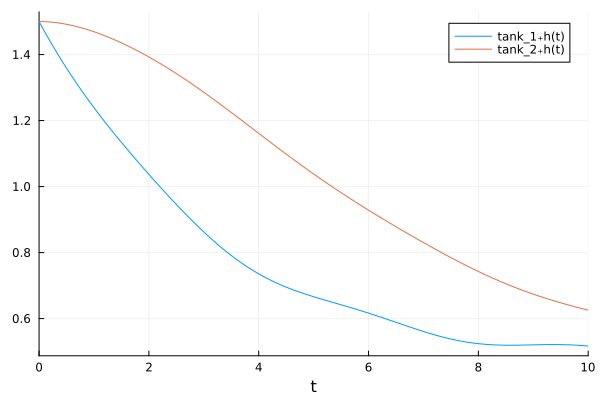

In [56]:
sol_2_tank = solve(prob_2_tank)

plot(sol_2_tank, idxs=[tank_1.h,tank_2.h])

### 3.5. Connecting two tanks in `Sys2Tank` model class
Above, we have connected two instances `tank_1` and `tank_2` manually on the command-line. A better way to do this is to do it in a *class*, in a similar way as we did for class `Tank`. 

To this end, let us now re-do what we have done, by creating a class `Sys2Tank` using macro `@mtkmodel`. This is a more modern way of creating the combined system, and is similar to how it is done in Modelica.

In [57]:
# Below, macro `mtkmodel` creates a model instantiator/"class" with name `Sys2Tank`
#
@mtkmodel Sys2Tank begin
    # Components used
    @components begin 
        tank_1 = Tank()
        tank_2 = Tank()
    end
    # Equations for connecting components
    @equations begin
        tank_1.md_i ~ md(t)
        tank_2.md_i ~ tank_1.md_e
    end
end
;

### 3.6. Instantiating `Sys2Tank` model as `sys2tank`

In [58]:
@named sys2tank_balanced = Sys2Tank()

sys2tank = structural_simplify(sys2tank_balanced) |> complete

Model sys2tank_balanced with 2 equations
States (2):
  tank_1₊m(t) [defaults to 1.5tank_1₊A*tank_1₊ρ]: Liquid mass
  tank_2₊m(t) [defaults to 1.5tank_2₊A*tank_2₊ρ]: Liquid mass
Parameters (8):
  tank_1₊ρ [defaults to 1]: Liquid density
  tank_1₊A [defaults to 5]: Cross sectional tank area
  tank_1₊K [defaults to 5]: Effluent valve constant
  tank_1₊h_ς [defaults to 3]: Scaling level in valve model
⋮
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ⋅  ×  ⋅
 ×  ×  ⋅  ×

In [59]:
sys2tank.name

:sys2tank_balanced

### 3.7. Solving model `sys2tank`
We now convert the symbolic model `sys2tank` to a numeric model `prob_sys`.

In [60]:
prob_sys = ODEProblem(sys2tank, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 10)
u0: 2-element Vector{Float64}:
 7.5
 7.5

Next, we solve problem `prob_sys`, and plot the results.

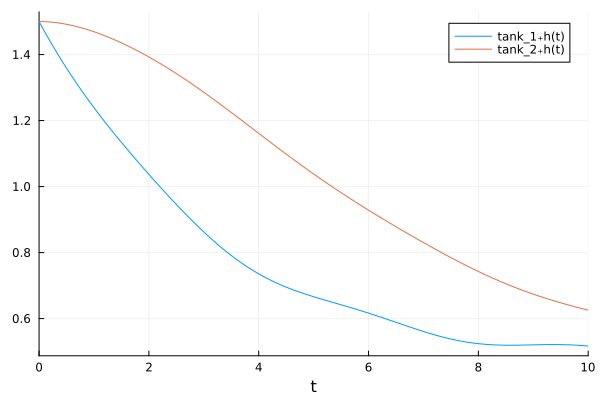

In [61]:
sol_sys = solve(prob_sys)

plot(sol_sys, idxs=[tank_1.h, tank_2.h])

## 4. Re-doing simulations
In the examples in this section, we will use the symbolic model `tanksys`, which has lead to problem `prob`.

### 4.1. Changing input function
So far, we have used the following input function $\dot{m}(t)$:
```julia
md(t) = 2 + 0.1*sin(2pi*t/4)
```
Let us see what happens when we change this function.

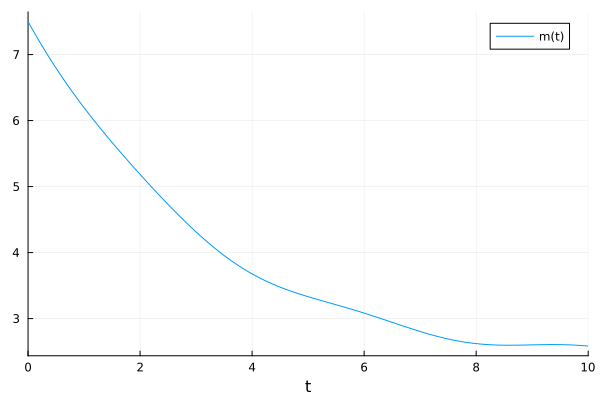

In [62]:
sol = solve(prob)

plot(sol)

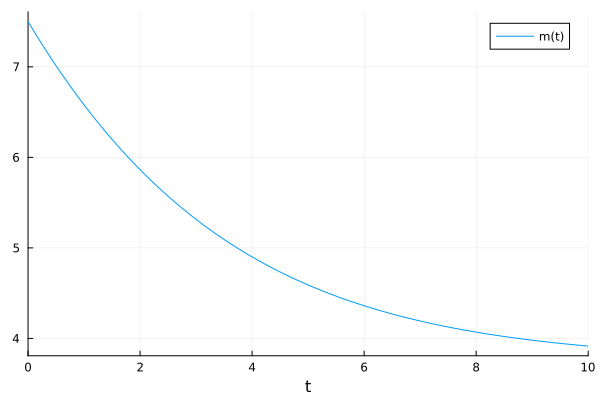

In [63]:
md(t) = 2.5
sol = solve(prob)

plot(sol)

*Observe* that we didn't have to re-generate the numeric problem in order to have a change in $\dot{m}(t)$ influence the solution!

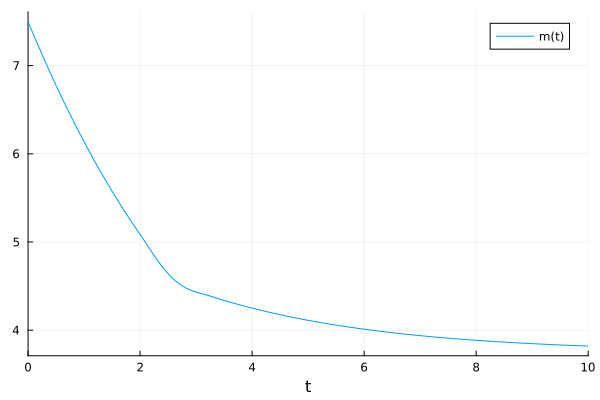

In [64]:
md(t) = t < 3 ? 2 : 2.5
sol = solve(prob)

plot(sol)

### 4.2. Step response from steady state
Two ways to find the steady state are to (i) solve the steady state model (set $\mathrm{d}m/\mathrm{d}t = 0$, and find the resulting $m$), and (ii) simulate the system (assuming the system is stable) sufficiently long to become steady, then read off the final value. Method no. (ii) is normally by far the simplest strategy.

In order to change the time span, we need to *recreate* the problem. This can be done in 2 ways, first, one can re-create the problem from the "grounds up":
```julia
tspan = (0,100)
prob = ODEProblem(tanksys,[],tspan)
```
Alternatively, and more efficiently, it is possible to *remake* the problem with the following syntax:
```julia
modified_problem = remake(original_problem;
                          keyword_1 = value_1,
                          keyword_2 = value_2,
                          ...)
```
where relevant *keywords* names are `tspan` for time span, `u0` for initial state, `p` for parameters, etc. As an example:
```julia
tspan = (0,100)
prob = remake(prob,tspan=tspan)
```
We find:

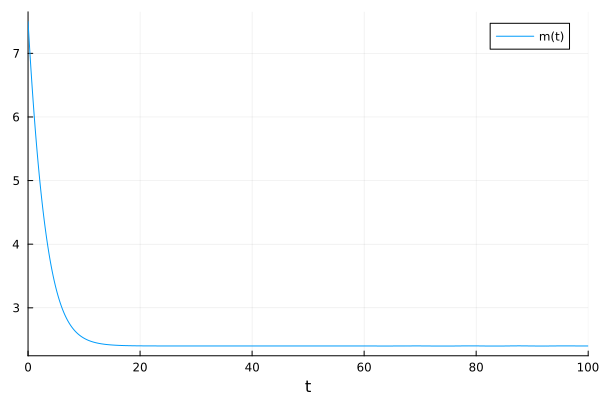

In [65]:
tspan=(0,100)
md(t) = 2
prob = remake(prob,tspan=tspan)
sol = solve(prob)

plot(sol)

It seems like we have reached steady state, so we read off the final value of the state ($m$) into variable name `m_ss`, remake the problem with this as initial state, and inject an input with a step change. 

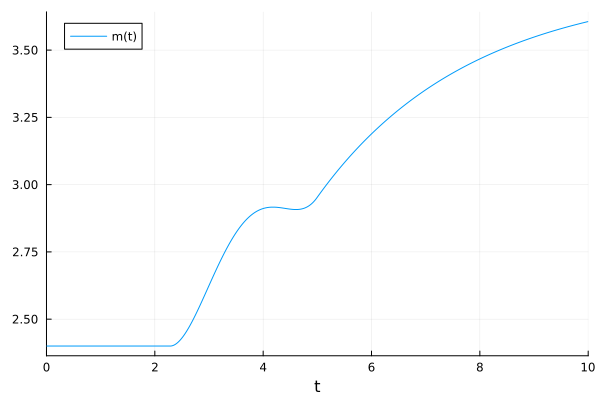

In [66]:
m_ss = sol(100)
tspan = (0,10)
prob_m = remake(prob, u0 = m_ss, tspan=tspan)

md(t) = t<3 ? 2 : 2.5
sol = solve(prob_m)

plot(sol)

This behavior is quite surprising, and definitely incorrect. What is going on? Let us consider the points in time where the solver has found a solution:

In [67]:
sol.t

7-element Vector{Float64}:
  0.0
  0.21688257515358147
  2.282068838305998
  4.993050131719505
  6.240056464483171
  8.808353117717335
 10.0

Observe that the solver starts to use relatively long timesteps *prior* to the time of the step change, which is $t=3$. The reason for this is probably that little is happing: the system starts in steady state, and stays close to/in steady state, and the solver can therefore take long steps. When the step in the input comes ($t=3$), the solver is not prepared for this, and steps from $t=2.28$ to $5$ in one step. Because of these long time steps, the interpolation function of the solution creates this artificial behavior with what looks like 2 steps.

Let us instead plot the solution with straight lines between the time poins:

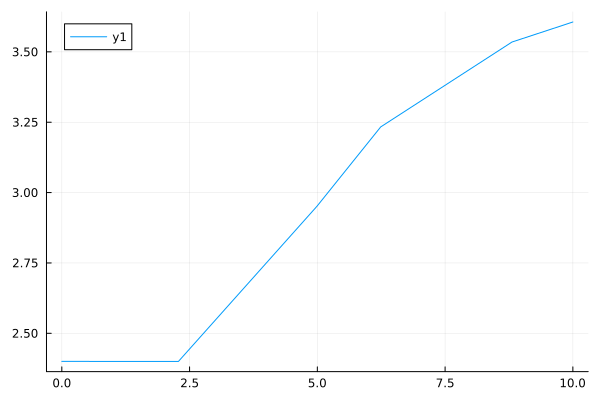

In [68]:
plot(sol[t], sol[m])

This plot confirms our suspicion about the reason for the weird plot with two apparent steps: now it looks more like a (slightly corrupted) first order step response.

Let us inform the solver that it should compute a solution point at $t=3$ to see if this helps:

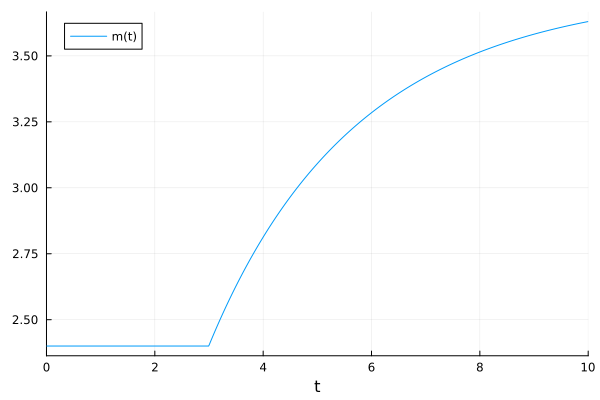

In [69]:
sol = solve(prob_m; tstops=3)
plot(sol)

We see that this solved the problem with the solution `sol`.

We could alternatively have used another solver which by default handles the problem better, e.g., the `QNDF` solver.

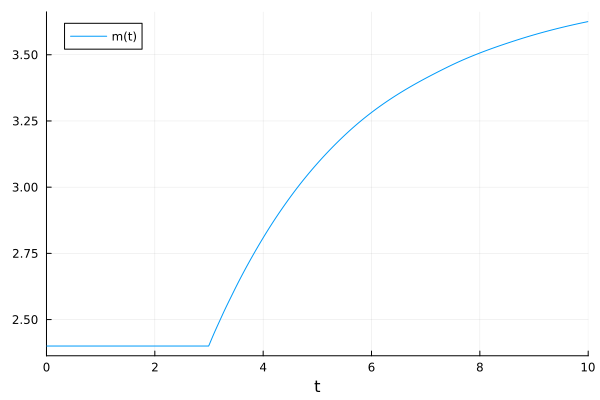

In [70]:
sol = solve(prob_m, QNDF())

plot(sol)

*Observe*: with the `QNDF` solver, we did not need to specify `tstops`.

### 5.3. Numeric problems with no inflow
Let us consider the case with zero influent, $\dot{m}(t) \equiv 0$. We'll use `tspan = (0,3.8)` for now.

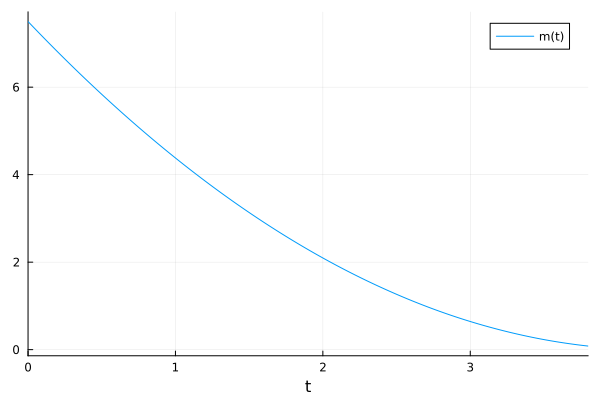

In [71]:
md(t) = 0
tspan = (0,3.8)
prob_m = remake(prob,tspan=tspan)

sol = solve(prob_m)

plot(sol)

It turns out that the solution *crashes* if we simulate the system more than 3.8 time units! The reason is that if we simulate slightly more than 3.8 time units, the level incorrectly becomes negative (due to numeric inaccuracies), and then we take the square root of a negative number, leading to a complex number, and the solution process breaks down.

Let us see how we can *robustify* the implementation. We do the following re-write:

$$
\sqrt{\frac{h}{h^\varsigma}} \rightarrow \max{\left( \mathrm{sign}(h)\cdot \sqrt{\frac{\left| h \right|}{h^\varsigma}}, 0 \right)}.
$$

The absolute value of the level is taken inside of the square root, to avoid generation of a complex number. We also include the sign function of level + the max value to make sure that the effluent flow rate is not allowed to *enter* the tank.

In [72]:
eqs_robust = [
    Dt(m) ~ md_i-md_e,
    m ~ ρ*V,
    V ~ A*h,
    md_e ~ K*max(sign(h)*sqrt(abs(h)/h_ς),0)
 ]

@named tank_robust = ODESystem(eqs_robust, t, vars, pars)    # Acausal tank model, i.e., 
                                                             # without defined input functions

Model tank_robust with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]: Liquid mass
  md_i(t): Influent mass flow rate
  md_e(t): Effluent mass flow rate
  V(t): Liquid volume
⋮
Parameters (4):
  ρ [defaults to 1]: Liquid density
  A [defaults to 5]: Cross sectional tank area
  K [defaults to 5]: Effluent valve constant
  h_ς [defaults to 3]: Scaling level in valve model

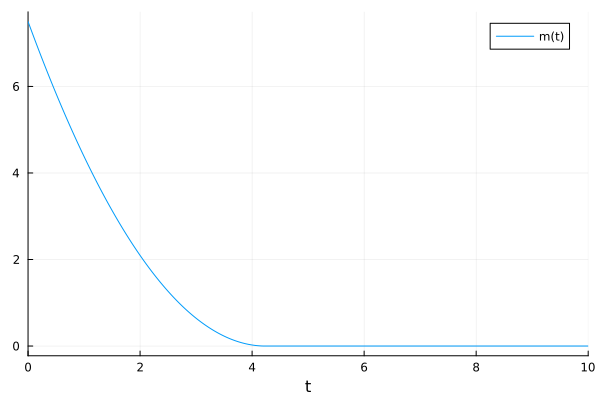

In [73]:
tank_bal_robust = extend(tank_robust,tank_i)

tanksys_robust = structural_simplify(tank_bal_robust)

tspan = (0,10)

prob_robust = ODEProblem(tanksys_robust, [], tspan)

sol_robust = solve(prob_robust)

plot(sol_robust)

In summary: when the model is operated in "extreme" conditions, it may be necessary to modify the implementation in order to avoid numerical problems.

### 5.4. Changing parameters
In many situations, we need to be able to re-simulate the system with different initial conditions or different model parameters. This is the case, e.g., if 
* We need to know how the model handles uncertainties in the initial values, or uncertainties in the model parameters (prediction uncertainty), 
* We need to *change* initial values or models in order to make the model fit better to experimental data (data fitting).

To study such situations, we may want to *remake* the model with new model parameters.

The standard way to do this with `DifferentialEquatons.jl` solvers is with syntax:
```julia
prob_rem = remake(prob; u0 = u0_new, p = p_new)
```

When we use MTK where parameters and initial values are *symbols*, this can be changed with a particularly simple syntax, e.g.:
```julia
prob[p] = p_new
```
Let us first re-create the original model problem we had:

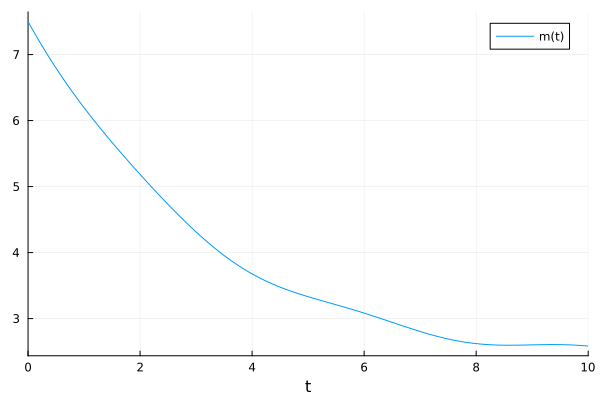

In [74]:
tspan = (0,10)

md(t) = 2 + 0.1*sin(2pi*t/4)

prob = ODEProblem(tanksys, [], tspan)

sol = solve(prob)

fg = plot(sol)

To re-capture, here are the default values:

In [75]:
ModelingToolkit.defaults(tanksys)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

Next, let us change parameter `A` from value 5 to value 6:

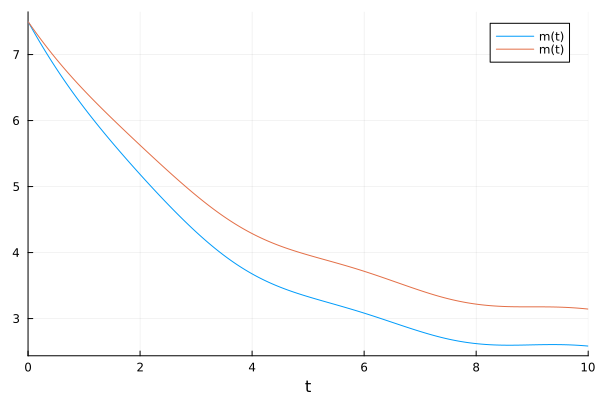

In [76]:
prob[A] = 6
sol = solve(prob)

plot!(fg, sol)

Next, let us draw values of 2 parameters from uniform random numbers in a loop:

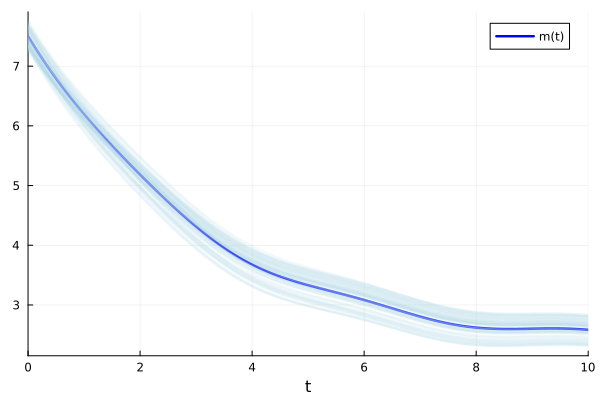

In [77]:
prob = ODEProblem(tanksys, [], tspan)
sol = solve(prob)

plot(sol, lw=LW1, lc=:blue)
for i in 1:50
    _A = 5 + (rand()-0.5)
    _m = 7.5 + 0.5*(rand()-0.5)
    prob[A] = _A
    prob[m] = _m
    sol = solve(prob)
    plot!(sol, lw=LW1, lc=:lightblue,la=LA3,label="")
end
plot!()

Alternatively, we could change both parameters in the problem simultaneously by explicit use of the `remake` function --- explicit use of the `remake` function is probably more efficient when we change more than one parameter.

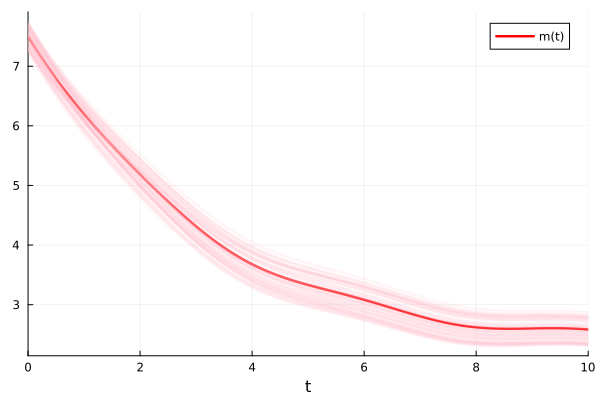

In [78]:
prob = ODEProblem(tanksys, [], tspan)
sol = solve(prob)

plot(sol, lw=LW1, lc=:red)
for i in 1:50
    _A = 5 + (rand()-0.5)
    _m = 7.5 + 0.5*(rand()-0.5)
    prob = remake(prob; u0=[_m], p=[A=> _A])
    sol = solve(prob)
    plot!(sol, lw=LW1, lc=:pink,la=LA3,label="")
end
plot!()

## 5. Index 1 DAE: Incompressible Liquid Pipe Flow
The following model illustrates a case where ModelingToolkit simplifies the model to an index 1 DAE, with resulting required use of mass matrix solver.

### 5.1. Model of pipe
We consider a pipe of length $L$ with cross sectional area $A_\mathrm{p}$, with incompressible liquid density $\rho$ and hence constant mass $m$,
$$
m = \rho A_\mathrm{p} L
$$
Because of incompressibility, the balance equation for momentum $\mathfrak{m}$ reduces to Newton's law with force $F$,
$$
\frac{\mathrm{d}\mathfrak{m}}{\mathrm{d} t} = F
$$
where momentum is
$$
\mathfrak{m} = mv
$$
and $v$ is linear velocity. Linear velocity is related to volumetric flow rate $\dot{V}$ as
$$
\dot{V} = A_\mathrm{p}v
$$
Mass flow rate $\dot{m}$ is related to volumetric flow rate as 
$$
\dot{m}_\mathrm{p} = \rho \dot{V}
$$
and is also given by the effluent pressure drop through a valve,
$$
\dot{m}_\mathrm{p} = K_\mathrm{e} u \sqrt{\frac{\Delta p_\mathrm{e}}{p^\varsigma}}
$$
where $u$ is the valve control signal (opening) and $\Delta p_\mathrm{e}$ is the pressure drop over the outlet valve. Here
$$
\Delta p_\mathrm{e} = p_\mathrm{e} - p_\mathrm{a}
$$
where $p_\mathrm{e}$ is the pressure in front of the valve, and atmospheric pressure $p_\mathrm{a}$ is the pressure at the exit from the valve.

Force $F$ is given as
$$
F = F_\mathrm{g} - F_\mathrm{f} + F_\mathrm{p}
$$
where gravity force $F_\mathrm{g} = m g H/L$ is constant with $H$ the elevation drop from pipe inlet to effluent valve, friction force $F_\mathrm{f}$ is
$$
F_\mathrm{f} = k\cdot v\cdot|v|.
$$
Pressure force $F_\mathrm{p}$ is
$$
F_\mathrm{p} = A_\mathrm{p}(p-p_\mathrm{e})
$$
with $p$ the pipe inlet pressure from a reservoir. The inlet from the reservoir is at position $h$ below the reservoir level, thus $p$ is given as 
$$
p = p_\mathrm{a} + \rho g h.
$$

In summary, we have:
* 11 parameters $\rho$, $L$, $A_\mathrm{p}$, $m$, $K_\mathrm{e}$, $p_\mathrm{a}$, $p^\varsigma$, $g$, $H$, $F_\mathrm{g}$, $k$
* 12 unknowns $v$, $\mathfrak{m}$, $F$, $\dot{V}$, $\dot{m}_\mathrm{p}$, $u$, $\Delta p_\mathrm{e}$, $p_\mathrm{e}$, $F_\mathrm{f}$, $F_\mathrm{p}$, $p$, $h$ 
* 10 equations

To complete the model, we need to specify the two inputs valve signal $u$ and reservoir level $h$.

### 5.2. Variables, parameters, and differentiaton operator

In [79]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1e3, L=200, A_p=1.5, m=ρ*A_p*L, K_e=2e3, p_a=1.01e5, p_ς=p_a, 
            g=9.81, H=100, F_g=m*g*H/L, k=4e4)
# Dependent variables 
vars = @variables (v(t)=2, 𝔪(t)=m*v, F(t), Vd(t)=v*A_p, md_p(t)=ρ*Vd, u(t)=0.5, 
            Δp_e(t)=p_ς*(md_p/K_e/u)^2, p_e(t), F_f(t), F_p(t), p(t), h(t))
;

### 5.3. Acausal model

In [80]:
eqs_a = [Dt(𝔪) ~ F,
        𝔪 ~ m*v,
        Vd ~ A_p*v,
        md_p ~ ρ*Vd,
        md_p ~ K_e*u*sqrt(Δp_e/p_ς),
        Δp_e ~ p_e - p_a,
        F ~ F_g - F_f + F_p,
        F_f ~ k*v*abs(v),
        F_p ~ (p-p_e)*A_p,
        p ~ p_a + ρ*g*h]

@named pipe_a = ODESystem(eqs_a, t, vars, pars)

Model pipe_a with 10 equations
States (12):
  v(t) [defaults to 2]
  𝔪(t) [defaults to m*v(t)]
  F(t)
  Vd(t) [defaults to A_p*v(t)]
⋮
Parameters (11):
  ρ [defaults to 1000.0]
  L [defaults to 200]
  A_p [defaults to 1.5]
  m [defaults to A_p*L*ρ]
⋮

### 5.4. Registering inputs + input model

In [81]:
@register_symbolic u_u(t)
@register_symbolic h_u(t)
#
eqs_i = [u ~ u_u(t),
            h ~ h_u(t)]
@named pipe_i = ODESystem(eqs_i)

Model pipe_i with 2 equations
States (2):
  u(t) [defaults to 0.5]
  h(t)
Parameters (0):

### 5.5. Composed model with simplification and states

In [82]:
pipe = extend(pipe_i, pipe_a)

pipe_simp = structural_simplify(pipe) |> complete

Model pipe_i with 2 equations
States (2):
  𝔪(t) [defaults to m*v(t)]
  Δp_e(t) [defaults to p_ς*((md_p(t) / (K_e*u(t)))^2)]
Parameters (11):
  ρ [defaults to 1000.0]
  L [defaults to 200]
  A_p [defaults to 1.5]
  m [defaults to A_p*L*ρ]
⋮
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ×  ×
 ×  ⋅  ×

In [83]:
states(pipe_simp)

2-element Vector{Any}:
 𝔪(t)
 Δp_e(t)

From the `pipe_simp` structure, which contains one differential equation and one algebraic equation, we observe that we must use an ODE solver with support for mass matrix. A good solver is, e.g., `QNDF()`.

Next, from the list of "states", we observe that we need to provide initial values for $\mathfrak{m}$ and $\Delta p_\mathrm{e}$. We have already provided this in the specification of the `vars` object.

### 5.6. Defining concrete inputs + time span + generating numeric problem

Before we can create the numeric problem, we need to define concrete functions to `u_u` and `h_u`.

In [84]:
h_u_const(t) = 5
u_u_const(t) = 0.5
u_u_step(t) = t<4 ? 0.5 : 0.4

h_u(t) = h_u_const(t)
u_u(t) = u_u_step(t)

tspan = (0,8)
;

In [85]:
prob = ODEProblem(pipe_simp, [], tspan)

# This problem appears to be tricky numerically, so not all algorithms will work. Also, because the structgurally
# simplified model contains an algebraic equation, it is necessary to find a solver that supports mass matrix



ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 8)
u0: 2-element Vector{Float64}:
 600000.0
 908999.9999999999

### 5.7. Solving model, and presenting results
Observe that we use solver `QNDF()`, which has mass matrix support and is of good quality.

In [86]:
sol = solve(prob,QNDF());

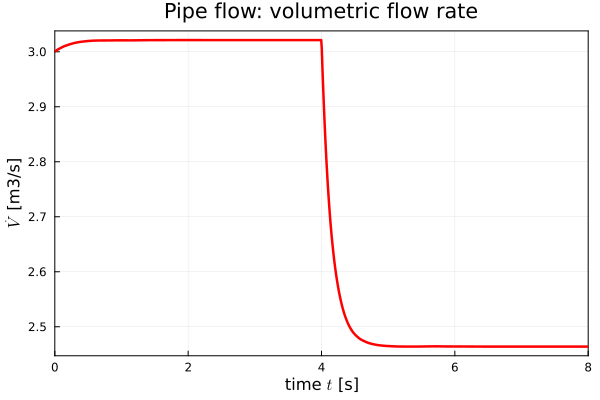

In [87]:
plot(sol,idxs=Vd, lw=LW1, lc=LC1, label="")
plot!(title="Pipe flow: volumetric flow rate",
    xlabel=L"time $t$ [s]", ylabel=L"$\dot{V}$ [m3/s]")
plot!(framestyle =:box, grid=true, legend=:topright)

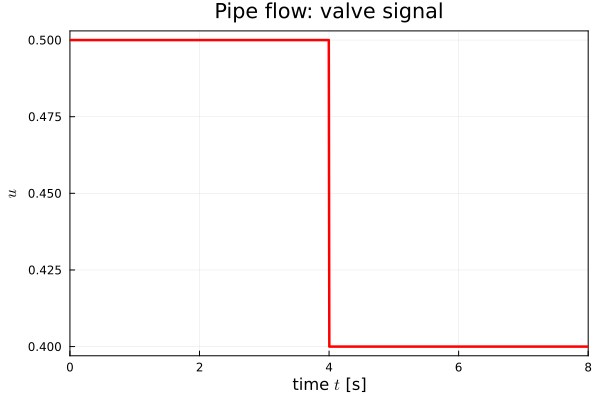

In [88]:
plot(sol,idxs=u, lw=LW1, lc=LC1, label="")
plot!(title="Pipe flow: valve signal",
    xlabel=L"time $t$ [s]", ylabel=L"u")
plot!(framestyle =:box, grid=true, legend=:topright)

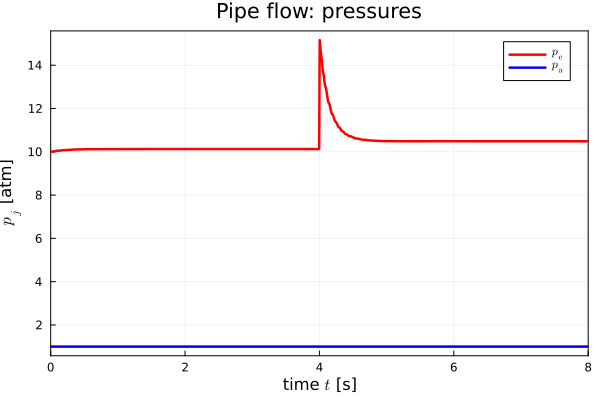

In [89]:
plot(sol,idxs=p_e/1.01e5, lw=LW1, lc=LC1, label=L"p_\mathrm{e}")
hline!([sol(0,idxs=p_a)/1.01e5],lw=LW1,lc=LC2,label=L"p_\mathrm{a}")
plot!(title="Pipe flow: pressures",
    xlabel=L"time $t$ [s]", ylabel=L"$p_j$ [atm]")
plot!(framestyle =:box, grid=true, legend=:topright)

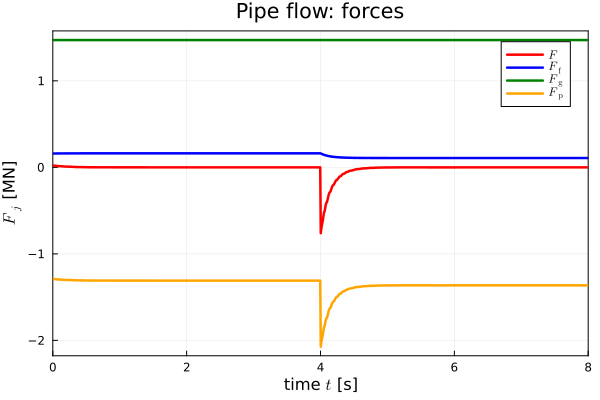

In [90]:
plot(sol,idxs=[F/1e6, F_f/1e6], lw=LW1, lc=[LC1 LC2], label=[L"F" L"F_\mathrm{f}"])
hline!([sol(0,idxs=F_g)/1e6],lw=LW1,lc=LC3,label=L"F_\mathrm{g}")
plot!(sol, idxs = F_p/1e6, lw=LW1, lc=LC4, label=L"F_\mathrm{p}")
plot!(title="Pipe flow: forces",
    xlabel=L"time $t$ [s]", ylabel=L"$F_j$ [MN]")
plot!(framestyle =:box, grid=true, legend=:topright)

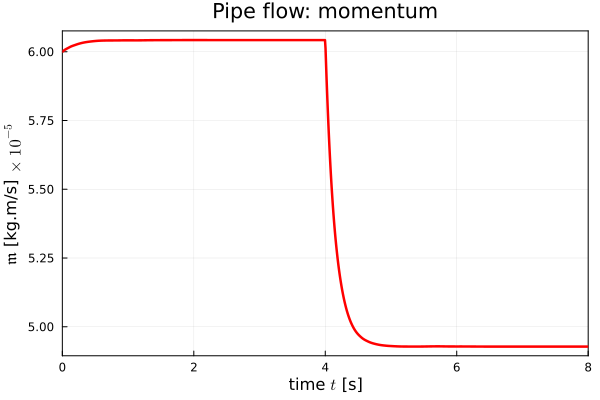

In [91]:
plot(sol,idxs=𝔪/1e5, lw=LW1, lc=LC1, label="")
plot!(title="Pipe flow: momentum",
    xlabel=L"time $t$ [s]", ylabel=L"$\mathfrak{m}$ [kg.m/s]$\ \times 10^{-5}$")
plot!(framestyle =:box, grid=true, legend=:topright)

### 5.8. Problems
1. Re-write the model using the `begin...end` block structure, and add `description` for better clarity of the presentation.
2. Re-write the model by creating a pipe "class" via the `@mtkmodel` macro, e.g., named `Pipe`.
3. Do a basic uncertainty analysis using the `remake` facility.

## 6. Linear model approximation
### 6.1. Purpose of linear approximation
Nonlinear DAE:s can be approximated by a linear state space model of form 
$$
\frac{\mathrm{d} x}{\mathrm{d}t} = Ax + Bu \\
y = Cx + Du
$$
where state $x$, input $u$, and output $y$ represent deviation from a fixed operating point, and $A$, $B$, $C$, and $D$ are constant state, input, output, and direct output matrices, respectively. Because the matrices are constant, this is referred to as a Linear Time Invariant [LTI] model.

If the deviations $x$, $u$, and $y$ from the operating point are "small", the responses in $x$ and $y$ on changes in $u$ (when adding the operating point values) should be quite similar to the nonlinear behavior (LTI models are sometimes known as "small-signal models"). 

Because rigorous analysis of stability etc. is straightforward for LTI models, such linear approximations are commonly used in introductory control studies. 

In this section, we will look at how to linearize models encoded in MTK *symbolically* [included utility functions in Section 0 assume a DAE of index 0 or 1] and *numerically*. We will also see how the linearized models can be used in the `ControlSystems.jl` and related packages.

### 6.2. Input functions

We will use two input functions: one with constant value of 2, `md_const(t)`, and one which starts at value 2 and then jumps down to value 1.5 at time = 1, `md_step(t)`. The actual influent function is denoted `md(t)`, and we set `md(t)` equal to one of `md_const(t)` and `md_step(t)`.

In [92]:
md_const(t) = 2
md_step(t) = t < 1 ? 2 : 1.5    # meaning: if t < 1, then 2, else 1.5
;

### 6.3. Constant influent
We have already registered the symbolic function `md(t)`. We now set `md(t)` equal to `md_const(t)`.

In [93]:
md(t) = md_const(t);

### 6.4. Recreating model
Normally, we should have been able to use model `tanksys` from previous sections. However, `tanksys` seems to have been slightly corrupted --- perhaps because of using symbolic parameters and variables in several model units. Because of this, we recreate the model.

In [94]:
# 1. Independent variables
@variables t 
# 2. Differential operator
Dt = Differential(t)
# 3. Parameters
pars = @parameters begin 
    ρ=1,    [description = "Liquid density"]
    A=5,    [description = "Cross sectional tank area"]
    K=5,    [description = "Effluent valve constant"]
    h_ς=3,  [description = "Scaling level in valve model"]
end
# 4. Dependent variables 
vars = @variables begin
    (m(t)=1.5*ρ*A),   [description = "Liquid mass"]
    md_i(t),         [description = "Influent mass flow rate"]
    md_e(t),         [description = "Effluent mass flow rate"]
    V(t),           [description = "Liquid volume"]
    h(t),           [description = "Liquid level"]
end

eqs = [
    Dt(m) ~ md_i-md_e,
    m ~ ρ*V,
    V ~ A*h,
    md_e ~ K*sqrt(h/h_ς)
 ]

@named tank = ODESystem(eqs, t, vars, pars)    # Acausal tank model, i.e., without defined input functions

eqs_i = [md_i ~ md(t)]

@named tank_i = ODESystem(eqs_i, t)

tank_bal = extend(tank,tank_i)

tanksys = structural_simplify(tank_bal)
;

### 6.5. Running simulation to find (numeric) steady state
We run the system for a "long" time with the constant input so that steady state is reached. Steady state will be the operating point that we use for linearizing the (acausal) model. A plot will indicate whether steady state has been reached, or not.

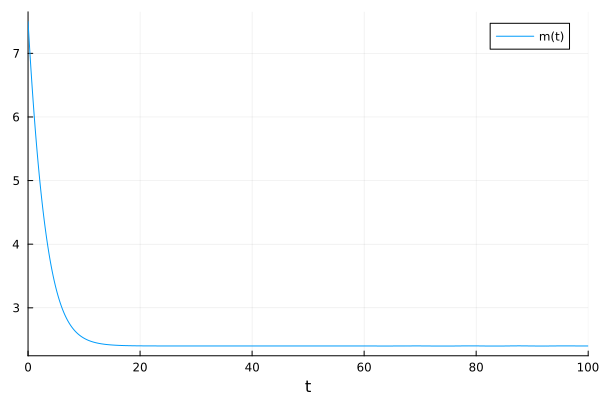

In [95]:
tspan = (0.0,100)

prob = ODEProblem(tanksys, [], tspan)
sol = solve(prob)
plot(sol, idxs=m)

The model appears to have reached steady state.

In the linearization process, we need numeric values of all the *variables* of the *acausal* model prior to adding input equations `eqs_i`, in other words: the `states` of model symbolic

In [96]:
states(tank)

5-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 m(t)
 md_i(t)
 md_e(t)
 V(t)
 h(t)

We thus read off the *names* `name_s` of the *acausal* model `tank` (= all variables), the numeric values  `s_ss` of these "states" (of the acausal model), mass `m_ss`, and level `h_ss` of the steady solution.

In [97]:
name_s = states(tank)
s_ss = sol(tspan[2]; idxs = name_s)
m_ss = sol(tspan[2]; idxs = m)
h_ss = sol(tspan[2]; idxs = h)
;

### 6.6. Symbolic linearization of model
We use the included utility function `linearize_symbolic_dae01` to linearize the *equations* `eqs` behind acausal model `tank` from input variable `u_tank` to output variable `y_tank`. The result is a tuple with symbolic matrices `As`, `Bs`, `Cs`, and `Ds`, as well as the name of the states, `x_name`. 

In [98]:
u_tank = [md_i]
y_tank = [h]

As, Bs, Cs, Ds, x_name = linearize_symbolic_dae01(eqs, u_tank, y_tank)
x_name

1-element Vector{Any}:
 m(t)

Observe that the returned model uses `m` as state. The symbolic matrices of the LTI model are:

In [99]:
As

1×1 Matrix{Num}:
 (-K) / (2A*h_ς*sqrt(h(t) / h_ς)*ρ)

In [100]:
Bs

1×1 Matrix{Num}:
 1.0

In [101]:
Cs

1×1 Matrix{Num}:
 1 / (A*ρ)

In [102]:
Ds

1×1 Matrix{Num}:
 0.0

### 6.7. Symbolic linearization with specified state
If we want to, we can specify the desired *state* in the linearized model:

In [103]:
x_tank = [h]

1-element Vector{Num}:
 h(t)

In [104]:
A1s, B1s, C1s, D1s, x_name = linearize_symbolic_dae01(eqs, u_tank, y_tank, x_opt=x_tank)
x_name

1-element Vector{Num}:
 h(t)

As seen, the state is now `h`. Let us check the change this has caused in the LTI matrices:

In [105]:
A1s

1×1 Matrix{Num}:
 (-K) / (2A*h_ς*sqrt(h(t) / h_ς)*ρ)

In [106]:
B1s

1×1 Matrix{Num}:
 1 / (A*ρ)

In [107]:
C1s

1×1 Matrix{Num}:
 1

In [108]:
D1s

1×1 Matrix{Num}:
 0.0

### 6.8. Numeric evaluation of symbolically linearized model
For the symbolic LTI matrices, the *first* step is to substitute the symbolic state names (`name_s`) for the numeric values of the operating point (`s_ss`), `name_s` $\rightarrow$ `s_ss`. The *second* step is to substitute any remaining symbols (e.g., parameters) with the *default* values of the system.In a third step, we need to "symbolically" `unwrap` the result to get standard numeric matrices in the result.

We have already found the state names (`name_s`) and their steady state values (`s_ss`); we will use these in the first step. Let us find the default values for the system which we need in the second step. 

In [109]:
default_vals = ModelingToolkit.defaults(tank)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

We are now ready to compute the numeric matrices (`As` $\rightarrow$ `Asn`, etc.) in a *three step process* which will be separated by the function piping operator `|>`:

In [110]:
Asn = substitute(As, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 -0.416647112138396

In [111]:
Bsn = substitute(Bs, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 1.0

In [112]:
Csn = substitute(Cs, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.2

In [113]:
Dsn = substitute(Ds, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.0

### 6.9. Creating a `ControlSystems` LTI object
We can use `ControlSystems` function `ss` to create an LTI object.

In [114]:
sys = ss(Asn, Bsn, Csn, Dsn)

ControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.416647112138396
B = 
 1.0
C = 
 0.2
D = 
 0.0

Continuous-time state-space model

### 6.9. Numeric evaluation with specified state
We redo the above computation of numeric matrices for the case where we specified the state.

In [115]:
A1sn = substitute(A1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 -0.416647112138396

In [116]:
B1sn = substitute(B1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.2

In [117]:
C1sn = substitute(C1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Int64}:
 1

In [118]:
D1sn = substitute(D1s, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 0.0

In [119]:
sys1 = ss(A1sn, B1sn, C1sn, D1sn)

ControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.416647112138396
B = 
 0.2
C = 
 1.0
D = 
 0.0

Continuous-time state-space model

### 6.10. Linearizing model symbolically using MTK
MTK provides an un-exported function `linearize_symbolic` for symbolic linearization, that has three positional arguments followed by a number of possible keyword arguments. The first positional argument is the acausal model (`tank`). The second positional argument is a vector of innput varariables ($u$), and the third positional argument is a vector of output variables ($y$).

The result is a tuple of (i) matrices `A`, `B`, `C`, and `D` collected in a named tuple (`mats` below), and (ii) a structurally simplified model (`tank_` below).

The returned tuple of matrices (`mats` below) can be unpacked via the "splash" operation in Julia (`...`), and then converted to a `ControlSystems` LTI model via the `ss` function of `ControlSystems`:

In [120]:
mats, tank_ = ModelingToolkit.linearize_symbolic(tank, [md_i], [h])
states(tank_)

1-element Vector{Any}:
 m(t)

In [121]:
mats.A

1×1 Matrix{Num}:
 (-K) / (2A*h_ς*sqrt(m(t) / (A*h_ς*ρ))*ρ)

In [122]:
mats.B

1×1 Matrix{Num}:
 1

In [123]:
mats.C

1×1 Matrix{Num}:
 1 / (A*ρ)

In [124]:
mats.D

1×1 Matrix{Num}:
 0

Observe that here, the result is the same as with using the utility function `linearize_symbolic_dae01`.

There may be cases where the results are not identical, though: utility function `linearize_symbolic_dae01` makes the strong assumption that the model is a DAE of index 0 or 1, while the MTK function `linearize_symbolic` makes no such assumption. In general, it can perhaps be assumed that function `linearize_symbolic_dae01` produces *simpler* results.

However, there is a huge advantage in using a function which is built-in into MTK (here: `linearize_symbolic`) instead of a "private" function (here: `linearize_symbolic_dae01`): the built-in function will be updated if any changes in the inner workings of MTK are implemented. In general, thus, it is recommended to use built-in functions in a package instead of ones own code.

The procedure for producing a numeric version of the matrix is similar to above:

In [125]:
substitute(mats.A, Dict(name_s .=> s_ss)) |> x -> substitute(x, default_vals) |> x -> Symbolics.unwrap.(x)

1×1 Matrix{Float64}:
 -0.416647112138396

### 6.11. Linearizing model numerically using MTK
We use the (exported) `linearize` function of MTK. Three positional arguments are the same as in `linearize_symbolic`. For numeric computation we can provide a numeric *operating point*. The *default* operating point is the default initial state and the input function(s) at time zero.

Normally the default operating point will not represent steady state, so the resulting linearized model will not the the constant matrices of the LTI. The desired operating point can be provide via a dictionary to keywoard argument `op`. Since `linearize` leads to a numeric linear approximation, function `linearize` will automatically insert the model parameters.

The result is a tuple of (i) matrices `A`, `B`, `C`, and `D` collected in a tuple (`mats` below), and (ii) a structurally simplified model (`tank_` below).

The returned tuple of matrices (`mats` below) can be unpacked via the "splash" operation in Julia (`...`), and then converted to a `ControlSystems` LTI model via the `ss` function of `ControlSystems`:

In [126]:
mats, tank_ = linearize(tank, [md_i], [h]; op=Dict(m=>m_ss, md_i=>md(0)))
ss(mats...)

ControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.4166471121383959
B = 
 1.0
C = 
 0.2
D = 
 -0.0

Continuous-time state-space model

We can now check the names of states, inputs, and outputs of the returned model `tank_` -- this is important for understanding the order of variables in the LTI model:

In [127]:
[states(tank_); ModelingToolkit.inputs(tank_); ModelingToolkit.outputs(tank_)]

3-element Vector{Any}:
 m(t)
 md_i(t)
 h(t)

### 6.12. Linearization using ControlSystemsMTK
Finally, we can linearize the system numerically using function `named_ss` of package `ControlSystemsMTK` --- which is an interface package between MTK and `ControlSystems.jl`. The arguments of `named_ss` are the same as those of `linearize` in MTK --- the key difference is that the returned solution has names of the states, inputs, and outputs baked into the returned data structure, and that the returned data structure can be directly converted to an LTI object.

In [128]:
sys_named = named_ss(tank, [md_i], [h]; op=Dict(m=>m_ss, md_i=>md(0)))

tank: NamedControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.4166471121383959
B = 
 1.0
C = 
 0.2
D = 
 -0.0

Continuous-time state-space model
With state  names: m(t)
     input  names: md_i(t)
     output names: h(t)


In [129]:
ss(sys_named)

ControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.4166471121383959
B = 
 1.0
C = 
 0.2
D = 
 -0.0

Continuous-time state-space model

### 6.13. Bode plot
We can use package `ControlSystems.jl` to do a Bode plot of the LTI system:

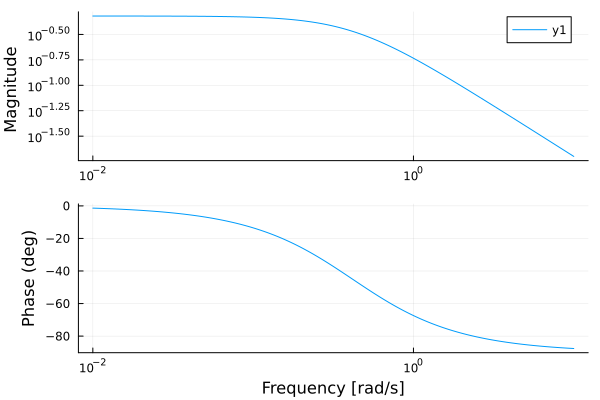

In [130]:
bodeplot(sys)

Often, we want to "improve" on the plot. As an example, we may want to use different colors for the magnitude and the phase, change the labels, modify the abscissa label, add a plot title, change grid color and line width, change background color, etc. We may also want to measure the amplitude in $\text{dB}$.

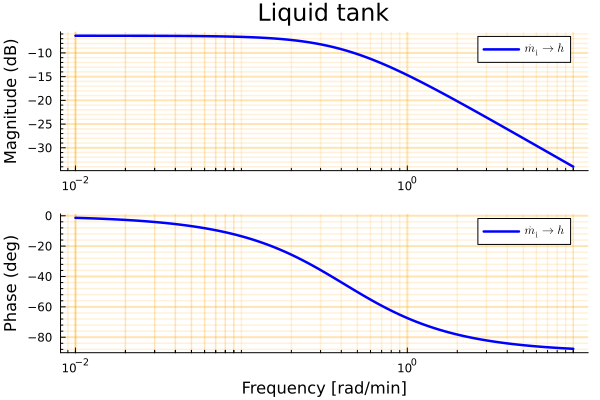

In [131]:
ControlSystemsBase.setPlotScale("dB")
bodeplot(sys, lw=LW1, lc=LC2, label = L"\dot{m}_\mathrm{i} \rightarrow h",
          xlabel = ["" "Frequency [rad/min]"], plot_title="Liquid tank",
          gridcolor=:orange, gridlinewidth=LW2, gridalpha=2LA3, minorgrid=true, 
          minorgridcolor=:orange,minorgridlinewidth=LW3, minorgridalpha=LA3,
          bg_color=:white)

### 6.14. Time constant
The concept of time constant is useful. We use the `LinearAlgebra.jl` package to compute eigenvalues, and then (assuming these are real and negative) compute the time constant. 

In [132]:
λ = eigvals(sys.A)[]
# Timeconstant(s)

τ = 1.0/abs.(λ)

2.4001126393691026

### 6.15. Plotting nonlinear & linearized model with time constant

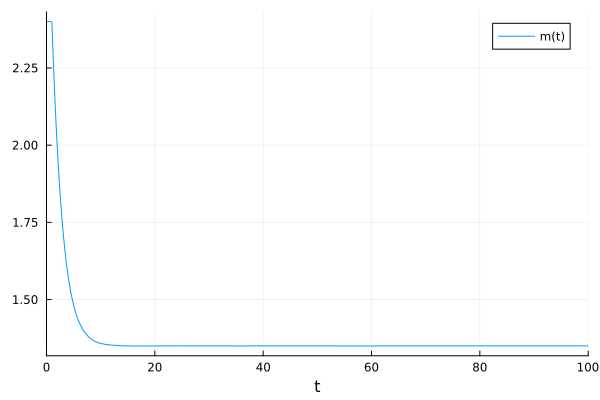

In [133]:
md(t) = md_step(t)

tspan = (0.0,100)

prob = ODEProblem(tanksys, [m_ss], tspan)

sol = solve(prob, QNDF())
plot(sol)

In [134]:
m_ss_ = sol(tspan[2]; idxs = m)
h_ss_ = sol(tspan[2]; idxs = h)
;

In [135]:
tspan = (0.0,10)
prob = ODEProblem(tanksys, [m_ss], tspan)
sol = solve(prob, QBDF())
#
# Non-linear solution
plot(sol, idxs=h, lw=LW1, lc=LC1, label=L"h_\mathrm{nonlin}")
;

In [136]:
# Finding linear case steady level after step
h_δ,t,x,md_δ = lsim(sys, (x,t) -> [md_step(t) - md_step(0)], 0:0.01:1e3)
h_δ_ss_ = h_δ[end]
# Simulating linear case
h_δ,t,x,md_δ = lsim(sys, (x,t) -> [md_step(t) - md_step(0)], 0:0.01:10)

# Tangent line
h_tangent(t) = h_ss + (t-1)*h_δ_ss_/τ
;

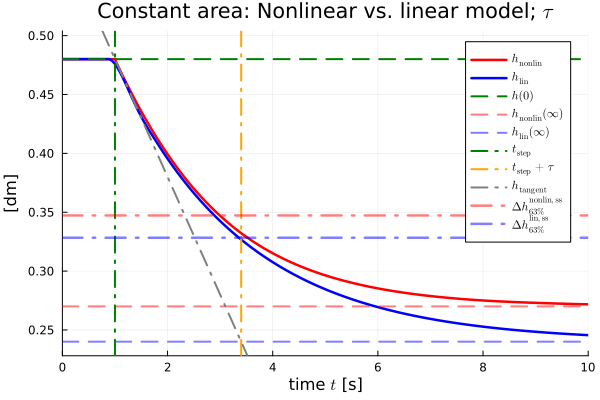

In [137]:
# Non-linear vs linear solution
plot!(t, permutedims(h_δ).+h_ss, lw=LW1, lc=LC2, label=L"h_\mathrm{lin}")
# Initial value
hline!([h_ss], lw=LW2, lc=LC3, ls=LS2, label=L"h(0)")
# Final value: nonlinear vs. linear
hline!([h_ss_], lw=LW2, lc=LC1, ls=LS2, la=LA2,label=L"h_\mathrm{nonlin}(\infty)")
hline!([h_ss + h_δ_ss_], lw=LW2, lc=LC2, ls=LS2, la=LA2,label=L"h_\mathrm{lin}(\infty)")
# Time where step takes place & step time + time constant
vline!([1], lw=LW2, lc=LC3,ls=LS3, label=L"t_\mathrm{step}")
vline!([1+τ], lw=LW2, lc=LC4,ls=LS3, label=L"t_\mathrm{step}+\tau")
# Tanget line for linear model at step
plot!(h_tangent, lw=LW2, lc=:gray,ls=LS3, label=L"h_\mathrm{tangent}")
# 63% rulers for non-linear and linear case
hline!([h_ss + (1-exp(-1))*(h_ss_-h_ss)], lw=LW1, lc=LC1,ls=LS3, la=LA2, label=L"\Delta h^\mathrm{nonlin,ss}_{63\%}")
hline!([h_ss + (1-exp(-1))*h_δ_ss_], lw=LW1, lc=LC2,ls=LS3, la=LA2, label=L"\Delta h^\mathrm{lin,ss}_{63\%}")
# Touching up with axis labels and title
plot!(xlabel=L"time $t$ [s]", ylabel = "[dm]")
plot!(title=L"Constant area: Nonlinear vs. linear model; $\tau$")
# Restricting ylims because of tangent line
plot!(ylims=((h_ss+h_δ_ss_)*0.95, h_ss*1.05))

## 7. Basics of `ModelingToolkitStandardLibrary`
We will re-do the tank system example with two tanks, and will use some functions in `ModelingToolkitStandardLibrary` instead of registering functions symbolically.

We will also use some `ModelingToolkitStandardLibrary` functionality for connecting the input function to the first tank, and for connecting the two tanks.

If *linearization* is considered, it is possible to insert so-called *Analysis Points*  in the signal path between two "blocks".

A final comment: syntax for MTK in building components + syntax for MTK Standard Library is in the process of being updated. Most likely, a standard name for *independent* time variable will be introduced (of necessity), and possibly also a standard name for the temporal differentiation operator. Other changes may also be introduced. Because of this, the presentation of MTK SL is somewhat limited for now.

### 7.1. Modified `Tank` class

This example provides a very simple introduction to basic use of `ModelingToolkitStandardLibrary`. We first slightly *modify* the `Tank` model class into "class" `Tank_m`, where we use the "block"/class `RealInput` from the `ModelingToolkitStandardLibrary`.

In [138]:
@mtkmodel Tank_m begin
    # Model parameters
    @parameters begin 
        ρ=1,    [description = "Liquid density"]
        A=5,    [description = "Cross sectional tank area"]
        K=5,    [description = "Effluent valve constant"]
        h_ς=3,  [description = "Scaling level in valve model"]
    end
    # Model variables, with initial values needed
    @variables begin
        m(t)=1.5*ρ*A,   [description = "Liquid mass"]
        # md_i(t),         [description = "Influent mass flow rate"]
        md_e(t),         [description = "Effluent mass flow rate"]
        V(t),           [description = "Liquid volume"]
        h(t),           [description = "level"]
    end
    # Components from ModelingTookitStandardLibrary
    @components begin
        # We move md_i from "variables" to "components"
        md_i = RealInput()  # Influent mass flow rate
        y_md_e = RealOutput()
    end
    # Providing model equations
    @equations begin
        Dt(m) ~ md_i.u-md_e
        m ~ ρ*V
        V ~ A*h
        md_e ~ K*sqrt(h/h_ς)
        y_md_e.u ~ md_e
    end
end
;

Observe that we have changed $\dot{m}_\mathrm{i}$ from being a variable, to being an input variable of class `RealInput` from `ModelingToolkitStandardLibrary`; we have indicated that we use a component from outside of class `Tank_m` by introducing it in the `@components` `begin...end` block. We have also defined a copy of the effluent flow as a `RealOutut`.

Definining input variables as `RealInput` and output variables as `RealOutput` allows us to specify causality in the system, and allows for considering the model component as a **block** from input to output. As we will see, when we connect *blocks*, it is possible to add "analysis points" in the signal pathway between blocks.

Also, notice that in the `@components` section, we can *not* add a description text string. The description is therefore provided as a comment.

### 7.2. Modified `Sys2Tank` class
We next created a modified system of 2 tanks, `Sys2Tank_m`. Two changes from the original `Sys2Tank` class which are relevant to using `ModelingToolkitStandardLibrary`:
1. We have changed $\dot{m}$ from being a registered symbolic function to being a function `Step()` from `ModelingToolkitStandardLibrary`.
2. In the `@equations` block, we have defined the connections using function `connect` instead of listing MTK *equations*.


These ideas are elaborated on in the following code:

In [139]:
@mtkmodel Sys2Tank_m begin
    @structural_parameters begin
        δmd = 0
    end
    # Components used
    @components begin 
        md = Step(height=2, offset=δmd)
        tank_1 = Tank_m()
        tank_2 = Tank_m()
    end
    # Equations for connecting components
    @equations begin
        connect(md.output, :u1, tank_1.md_i)
        connect(tank_1.y_md_e, :u2, tank_2.md_i)
    end
end
;

The reason for the changes are:
    * With the change in *Point 1* [use of `Step` input] + having made component `Tank_m` an input-output *block*, this allows us to insert "analysis points" between connections.
    * With the change in *Point 2*, this is in anticipation of using a Graphical User Interface to set up the `Sys2Tank` class.

**Analysis point**: An analysis point is a Julia *symbol* given to a certain connection, which allows us to refer to this point in analysis such as linearization. In the code above, we have introduced an analysis point named `:u` in the connect statement where we connect $\dot{m}$ to $\dot{m}_\mathrm{i}$ of `tank_1`, e.g., 

```julia
connect(md.output, :u1, tank_1.md_i)
```

This allows us to later on ask for an automatically computed linearized model between symbol `:u` and whatever other variable we are interested in.

**Use of `connect`-function**: Use of a `connect` function instead of an *equation* allows for an automatic set-up of the `Sys2Tank_m` class using a GUI system. 

Essentially, if we have the `Tank` class in a model library pallette (together with a `Constant` block), we simply take the `Constant` block and drag it into a GUI canvas, then we drag two copies of the `Tank` class into the canvas.

Next, we can draw a connector line from the `Constant` block to the input of the first `Tank` block. This line connects to the correct "input" of the first `Tank` block because $\dot{m}_\mathrm{i}$ has been defined as `RealInput` in the `Tank` class.

Finally, we drag a line from the first `Tank` block to the second `Tank` block. Because we have defined $\dot{m}_\mathrm{e}$ as a `RealOutput` in the `Tank` class, the system knows what the output value is. 

In summary, `RealInput` and `RealOutput` specifies what are the input connectors and output connectors of a class - which can be used by a GUI for building the class `Sys2Tank_m`. In practice, we need to add some more information on the inputs and outputs to make them proper connectors --- e.g., so that we can handle vectors of inputs and outputs with a given order, specify whether the inputs and outputs are "flows" or "potentials", etc. We will not go into these details here.

### 7.3. Instantiation and simulation of system
When instantiating a complete model from a *class*, like the `Sys2Tank_m` class, macro `@mtkbuild` can be used:
```julia
@mtkbuild xxx = Sys2Tank_m()
```

Macro `@mtkbuild` in effect combines the following three steps:
```julia
@name zzz = Sys2Tank_m()
yyy = structural_simplify(zzz)
xxx = complete(yyy)
```
Using macro `@mtkbuild`, we find:

In [140]:
@mtkbuild sys2tank_m = Sys2Tank_m()

Model sys2tank_m with 2 equations
States (2):
  tank_1₊m(t) [defaults to 1.5tank_1₊A*tank_1₊ρ]: Liquid mass
  tank_2₊m(t) [defaults to 1.5tank_2₊A*tank_2₊ρ]: Liquid mass
Parameters (12):
  md₊offset [defaults to 0]
  md₊start_time [defaults to 0]
  md₊height [defaults to 2]
  md₊duration [defaults to Inf]
⋮
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ⋅  ×  ⋅
 ×  ×  ⋅  ×

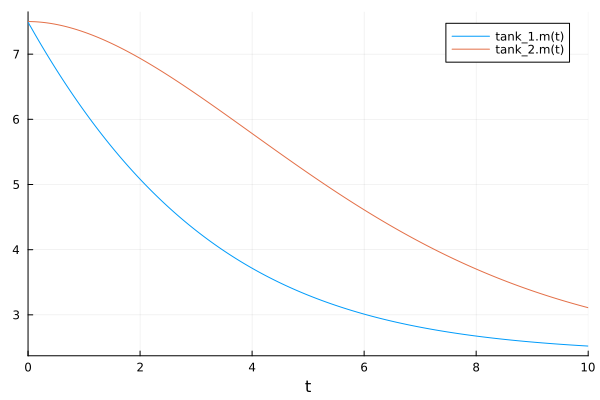

In [141]:
prob = ODEProblem(sys2tank_m, [], tspan)
sol = solve(prob)

plot(sol)

### 7.4. Use of analysis points for linearization
#### Linearization via MTK
Let us briefly see how we can take advantage of the *analysis points* which have been defined in class `Sys2Tank_m`. *Analysis points*  play a dual rôle:
* An analysis point can be considered an "extra input" in the connection point which provides an "extra variable". For normal simulation, this input can be considered to be grounded to zero, thus providing a balanced model. For linearization, this "extra variable" can be considered undefined thus leading to an acausal model --- previously, we have required an acausal model with undefined inputs in order to compute Jacobians from the input to the output.
* An analysis point can also be considered a "sensor" put into the signal pathway, which can be used as an output in linearization.

**Observe** that (at the moment) linearization has to be done on a *non-simplified* model, i.e., it doesn't work if the `structural_simplify` function has been applied to the model object. This means that we can *not* use a model instansiated via macro `@mtkbuild`! Instead, we have to instansiate it via macro `@named`, followed by applying the `complete` function.

In [142]:
@named sys2tank_ns = Sys2Tank_m()
sys2tank_ns = complete(sys2tank_ns)
;

Linearization can be done via ModelingToolkit function `linearize`, producing $A, B, C, D$ matrices for a linear state space model approximation at the given operating point. The result is a *tuple* where:
* the first element is a *named tuple* containing the system matrices, 
* the second element contains a simplified version of the model, including information about state order, etc.

In [143]:
mtx,  sys_simp = linearize(sys2tank_ns, [:u1,:u2], [sys2tank_ns.tank_1.m,sys2tank_ns.tank_2.m])

mtx.A

2×2 Matrix{Float64}:
 -0.235702  -0.0
  0.235702  -0.235702

In [144]:
mtx.B

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [145]:
mtx.C

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [146]:
mtx.D

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

#### Linearization via the ControlSystems eco-system
Alternatively, we can use function `named_ss` in package `ControlSystemsMTK.jl`. The latter method (`named_ss`) explicitly returns the names of the states, input variables, and output variables.

In [147]:
using ControlSystemsMTK

lin_sys2tank = named_ss(sys2tank_ns, [:u1,:u2], [sys2tank_ns.tank_2.m])

sys2tank_ns: NamedControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.2357022603955158  -0.0
  0.2357022603955158  -0.2357022603955158
B = 
 1.0  0.0
 0.0  1.0
C = 
 0.0  1.0
D = 
 0.0  0.0

Continuous-time state-space model
With state  names: tank_1₊m(t) tank_2₊m(t)
     input  names: u1 u2
     output names: tank_2₊m(t)


In [148]:
lin_sys2tank.A

2×2 Matrix{Float64}:
 -0.235702  -0.0
  0.235702  -0.235702

In [149]:
lin_sys2tank.B

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [150]:
lin_sys2tank.C

1×2 Matrix{Float64}:
 0.0  1.0

In [151]:
lin_sys2tank.D

1×2 Matrix{Float64}:
 0.0  0.0

### 7.5. Using linearized models in `ControlSystems.jl`
Finally, let us see how we can create an LTI (Linear Time Invariant) object in the `ControlSystems.jl` package.

First with the matrix tuple from function `linearize` in `ModelingToolkit`:

In [152]:
using ControlSystems

ss(mtx.A,mtx.B,mtx.C,mtx.D)

ControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.2357022603955158  -0.0
  0.2357022603955158  -0.2357022603955158
B = 
 1.0  0.0
 0.0  1.0
C = 
 1.0  0.0
 0.0  1.0
D = 
 0.0  0.0
 0.0  0.0

Continuous-time state-space model

Alternatively, we use use the result from the `named_ss` function of `ControlSystemsMTK`:

In [153]:
ss(lin_sys2tank)

ControlSystemsBase.StateSpace{Continuous, Float64}
A = 
 -0.2357022603955158  -0.0
  0.2357022603955158  -0.2357022603955158
B = 
 1.0  0.0
 0.0  1.0
C = 
 0.0  1.0
D = 
 0.0  0.0

Continuous-time state-space model

As we see, the linear model from the `named_ss` linearization function of `ControlSystemsMTK` works more directly with `ControlSystems` compared with the linear model from the `linearize` linearization function of `ModelingToolkit`.

We can now, e.g., do a so-called *Bode plot* of the model:

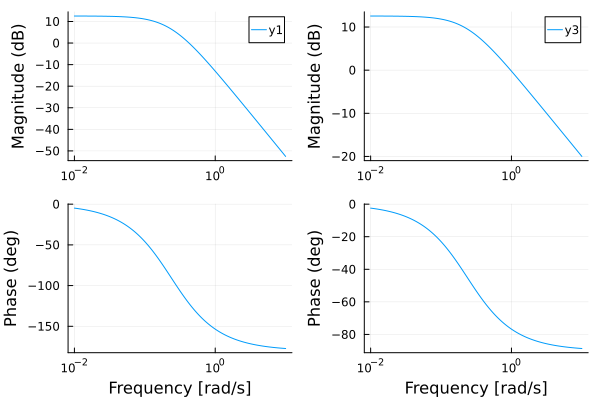

In [154]:
bodeplot(ss(lin_sys2tank))

### 7.6. Linearization/step around steady state
So far, we have linearized around the default operating point. In practice, we want to linearize the system around steady state.

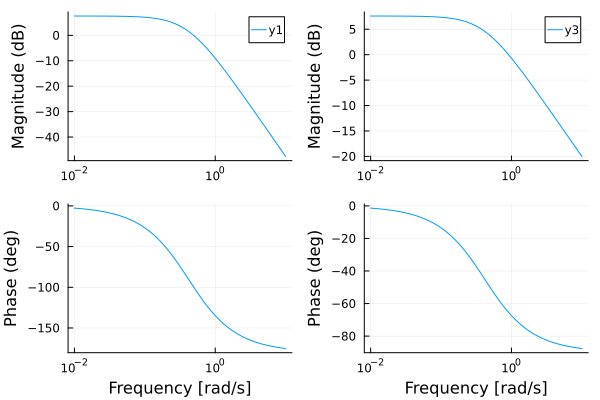

In [155]:
tspan = (0,100)
prob_ss = remake(prob, tspan=tspan)

sol = solve(prob_ss)

x_ss = sol[end]

lin_sys2tank = named_ss(sys2tank_ns, [:u1,:u2], [sys2tank_ns.tank_2.m]; 
    op = Dict(tank_1.m => x_ss[1], tank_2.m => x_ss[2])) |> ss

bodeplot(lin_sys2tank)



To inject a step change, we need to re-build the model where we set the `structural_parameter` $\delta\dot{m}$ equal to the step-change. Then we need to set the initial values of the states equal to `x_ss` and use the relevant `tspan`.

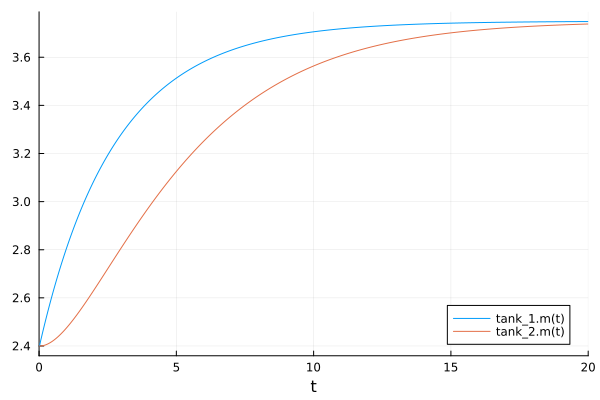

In [156]:
tspan = (0,20)
@mtkbuild sys2tank_m = Sys2Tank_m(; δmd=0.5)

prob_step = ODEProblem(sys2tank_m, x_ss, tspan)

sol = solve(prob_step)
plot(sol)

## 8. Summary

This notebook gives an application oriented introduction to ModelingToolkit [MTK] for Julia by considering a simple tank model and a simple pipe model. Learning points are:

* A "best practice" approach for describing dynamic models symbolically via MTK, but with reference to alternative ways of doing it, 
* A discussion of how to convert the symbolic model to a numeric problem which is then solved, and a discussion of the solution data structure,
* A discussion of basic creation of re-usable model components, with instantiation of two copies which are then connected,
* A discussion of re-doing simulations with changed inputs (e.g., with step responses from steady-state), as well as changed parameters (e.g., parametric uncertainty),
* Illustration of problems leading to Differential Algebraic Equations (DAE:s) of index 1, which require solvers with mass matrix support,
* A discussion of how to find linearized model approximation of nonlinear (DAE) models which can be integrated with the `ControlSystems.jl` and related packages, and finally
* A brief introduction to core use of MTK Standard Library, with analysis points for doing linearization in causal/balanced models.
